## Starting ##

Simple RL agent using Q-learning tables having 12 states.

In [ ]:
import numpy as np
import pandas as pd
from collections import defaultdict
import random
import time
import pickle
import os
from datetime import datetime


class FirewallEnvironment:
    def __init__(self, data):
        self.data = data
        self.current_step = 0
        self.state_size = 12  # Based on your state design
        self.action_space = [0, 1, 2]  # 0=allow, 1=deny, 2=inspect
        self.n_actions = len(self.action_space)

    def reset(self):
        """Reset environment to initial state"""
        self.current_step = 0
        return self._get_state(self.current_step)

    def step(self, action):
        """Take action and return next state, reward, done"""
        current_state = self._get_state(self.current_step)

        # Get actual action from data for reward calculation
        actual_action = self._get_actual_action(self.current_step)

        # Calculate reward based on agent's action vs actual action
        reward = self._calculate_reward(action, actual_action, current_state)

        # Move to next step
        self.current_step += 1
        done = self.current_step >= len(self.data) - 1

        next_state = self._get_state(self.current_step) if not done else None

        return next_state, reward, done

    def _get_state(self, step):
        """Convert raw data to state representation - STEP 1: Feature Engineering"""
        row = self.data.iloc[step]

        state = [
            # 1. Port Type Classification
            # 0: Source port type
            self._get_port_type(row['Source Port']),
            # 1: Destination port type
            self._get_port_type(row['Destination Port']),

            # 2. Protocol Inference
            # 2: Protocol type
            self._infer_protocol(row['Destination Port']),

            # 3. Traffic Volume Metrics
            # 3: Normalized bytes sent
            self._normalize_bytes(row['Bytes Sent']),
            # 4: Normalized bytes received
            self._normalize_bytes(row['Bytes Received']),
            row['pkts_sent'],                                # 5: Packets sent
            # 6: Packets received
            row['pkts_received'],

            # 4. Temporal Features
            self._normalize_duration(
                row['Elapsed Time (sec)']),  # 7: Session duration
            self._get_time_of_day(),                         # 8: Time of day

            # 5. Historical Context Features
            # 9: Historical success rate
            self._get_historical_success_rate(step),
            self._get_geographic_risk(),                     # 10: Geographic risk score
            self._get_service_frequency(
                row['Destination Port'])  # 11: Service frequency
        ]

        return np.array(state, dtype=np.float32)

    def _get_port_type(self, port):
        """STEP 1A: Categorize port types for better generalization"""
        if port <= 1023:
            return 0  # Well-known ports (0-1023)
        elif port <= 49151:
            return 1  # Registered ports (1024-49151)
        else:
            return 2  # Ephemeral ports (49152-65535)

    def _infer_protocol(self, dest_port):
        """STEP 1B: Infer protocol from destination port"""
        # Common TCP services
        tcp_ports = [80, 443, 22, 23, 25, 53, 110, 143, 993, 995, 3389]
        # Common UDP services
        udp_ports = [53, 67, 68, 69, 123, 161, 162, 514]

        if dest_port in tcp_ports:
            return 0  # TCP-like behavior
        elif dest_port in udp_ports:
            return 1  # UDP-like behavior
        else:
            return 2  # Unknown/Other protocol

    def _normalize_bytes(self, bytes_value):
        """STEP 1C: Normalize byte values using log scale"""
        return np.log1p(bytes_value) / 10.0  # Log normalization

    def _normalize_duration(self, duration):
        """STEP 1D: Normalize session duration"""
        return min(duration / 3600.0, 1.0)  # Normalize to 0-1 range (1 hour max)

    def _get_time_of_day(self):
        """STEP 1E: Simulate time of day feature"""
        return random.randint(0, 23) / 23.0  # Normalized to 0-1

    def _get_historical_success_rate(self, step):
        """STEP 1F: Calculate historical success rate for similar connections"""
        if step == 0:
            return 0.5  # Default for first connection

        # Simplified: count successful connections so far
        successful_connections = len([i for i in range(step)
                                      if self.data.iloc[i]['Action'] == 'allow'])
        return successful_connections / step

    def _get_geographic_risk(self):
        """STEP 1G: Placeholder for geographic risk intelligence"""
        # In production, this would integrate with threat intelligence feeds
        return random.uniform(0, 1)  # Simulated risk score

    def _get_service_frequency(self, dest_port):
        """STEP 1H: Calculate service frequency in the network"""
        port_counts = self.data['Destination Port'].value_counts()
        total_connections = len(self.data)
        frequency = port_counts.get(dest_port, 0) / total_connections
        return min(frequency * 10, 1.0)  # Normalized

    def _get_actual_action(self, step):
        """STEP 2: Map actual firewall actions to our action space"""
        action_str = self.data.iloc[step]['Action']

        # Map original actions to our 3-action space
        if action_str == 'allow':
            return 0  # allow
        elif action_str in ['deny', 'drop']:
            return 1  # deny
        else:  # reset-both and others
            return 2  # inspect

    def _calculate_reward(self, predicted_action, actual_action, state):
        """REDESIGNED REWARD FUNCTION: Focus on accuracy with balanced rewards"""
        
        # ===== BASE REWARD FOR ACTION MATCHING =====
        if predicted_action == actual_action:
            base_reward = 10  # Reward for correct prediction
        else:
            base_reward = -5  # Penalty for wrong prediction
        
        # ===== CONTEXT-AWARE ADJUSTMENTS =====
        context_reward = 0
        
        # Extract state features
        src_port_type, dest_port_type, protocol = state[0], state[1], state[2]
        geo_risk, service_freq, hist_success = state[10], state[11], state[9]
        
        # Security-critical scenarios
        if geo_risk > 0.7:  # High geographic risk
            if predicted_action == 0 and actual_action == 1:  # WRONG: Allowed malicious
                context_reward -= 20
            elif predicted_action == 1 and actual_action == 1:  # CORRECT: Denied malicious  
                context_reward += 15
            elif predicted_action == 2:  # SMART: Inspected high-risk
                context_reward += 8
        
        # Suspicious port patterns
        if src_port_type == 2 and dest_port_type == 0:  # Ephemeral -> Well-known
            if predicted_action == 0 and actual_action == 1:  # WRONG
                context_reward -= 15
            elif predicted_action == 2:  # SMART inspection
                context_reward += 10
        
        # Performance optimization
        if dest_port_type == 0 and geo_risk < 0.3:  # Legitimate business traffic
            if predicted_action == 1 and actual_action == 0:  # WRONG: Denied legitimate
                context_reward -= 12
            elif predicted_action == 0 and actual_action == 0:  # CORRECT: Allowed legitimate
                context_reward += 8
        
        # INSPECT action cost-benefit analysis
        if predicted_action == 2:
            inspection_cost = -3  # Base cost of inspection
            
            # When INSPECT is justified
            if (0.4 <= geo_risk <= 0.6 or 
                (src_port_type == 2 and dest_port_type == 0) or
                service_freq > 0.7):
                inspection_cost += 5  # Reduce cost for justified inspection
            
            # When INSPECT is unnecessary  
            if (geo_risk < 0.2 and hist_success > 0.8 and 
                dest_port_type == 0 and actual_action == 0):
                inspection_cost -= 5  # Extra penalty for unnecessary inspection
                
            context_reward += inspection_cost
        
        # ===== CALCULATE TOTAL REWARD =====
        total_reward = base_reward + context_reward
        
        # ===== BOUND THE REWARD TO PREVENT EXPLOSION =====
        total_reward = max(-25, min(25, total_reward))
        
        return total_reward

    def _calculate_security_modifier(self, action, state):
        """Remove this function since we've integrated security into main reward"""
        return 0  # Now handled in main reward function


class QLearningAgent:
    def __init__(self, state_size, action_size, 
                 learning_rate=0.1,        # REDUCED from 0.2
                 discount_factor=0.95,     # INCREASED future focus
                 exploration_rate=1.0,
                 exploration_decay=0.99,   # SLOWER decay
                 min_exploration=0.1):     # HIGHER minimum exploration
        """
        OPTIMIZED PARAMETERS FOR STABLE LEARNING
        """
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        self.exploration_decay = exploration_decay
        self.min_exploration = min_exploration
        
        # Initialize Q-table with small random values to encourage exploration
        self.q_table = defaultdict(lambda: np.random.uniform(-0.1, 0.1, action_size))

    def choose_action(self, state):
        """STEP 4A: Choose action using epsilon-greedy strategy"""
        # Convert state to tuple for use as dictionary key (discretization)
        state_key = tuple(state.astype(np.float16))

        # Exploration: choose random action
        if np.random.random() < self.exploration_rate:
            return np.random.choice(self.action_size)
        # Exploitation: choose best known action
        else:
            return np.argmax(self.q_table[state_key])

    def learn(self, state, action, reward, next_state, done):
        """STEP 4B: Update Q-table using Q-learning algorithm"""
        state_key = tuple(state.astype(np.float16))
        next_state_key = tuple(next_state.astype(
            np.float16)) if next_state is not None else None

        # Current Q-value for the taken action
        current_q = self.q_table[state_key][action]

        # Calculate target Q-value
        if done:
            target = reward  # If episode ended, target is just the reward
        else:
            # Bellman equation: Q(s,a) = R + γ * max(Q(s',a'))
            target = reward + self.discount_factor * \
                np.max(self.q_table[next_state_key])

        # Q-learning update rule
        self.q_table[state_key][action] = current_q + \
            self.learning_rate * (target - current_q)

        # Decay exploration rate after each episode
        if done:
            self.exploration_rate = max(self.min_exploration,
                                        self.exploration_rate * self.exploration_decay)


def train_firewall_agent(data, episodes=1000):
    """
    IMPROVED TRAINING LOOP WITH REWARD NORMALIZATION
    """
    print("Initializing Firewall Environment...")
    env = FirewallEnvironment(data)

    print("Initializing Q-learning Agent...")
    agent = QLearningAgent(env.state_size, env.n_actions)

    rewards_history = []
    accuracy_history = []
    
    # Track episode statistics for better debugging
    episode_rewards = []
    episode_accuracies = []

    print("Starting Training...")
    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        correct_predictions = 0
        total_predictions = 0
        done = False

        while not done:
            # Agent chooses action
            action = agent.choose_action(state)

            # Environment executes action and provides feedback
            next_state, reward, done = env.step(action)

            # Agent learns from experience
            agent.learn(state, action, reward, next_state, done)

            # Track performance
            total_reward += reward
            total_predictions += 1

            # Check if prediction was correct
            actual_action = env._get_actual_action(env.current_step - 1)
            if action == actual_action:
                correct_predictions += 1

            state = next_state

        # Calculate episode accuracy
        episode_accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
        accuracy_history.append(episode_accuracy)
        rewards_history.append(total_reward)
        
        # Store for rolling average
        episode_accuracies.append(episode_accuracy)
        episode_rewards.append(total_reward)

        # Calculate rolling averages (last 10 episodes)
        avg_reward = np.mean(episode_rewards[-10:]) if len(episode_rewards) >= 10 else np.mean(episode_rewards)
        avg_accuracy = np.mean(episode_accuracies[-10:]) if len(episode_accuracies) >= 10 else np.mean(episode_accuracies)

        # Progress reporting with Q-table stats
        if episode % 10 == 0:  # Report every 10 episodes
            q_table_size = len(agent.q_table)
            non_zero_q_values = sum(1 for q_vals in agent.q_table.values() 
                                   if np.any(np.abs(q_vals) > 0.1))
            
            print(f"Episode {episode:4d} | "
                  f"Reward: {total_reward:6.1f} | "
                  f"Accuracy: {episode_accuracy:.3f} | "
                  f"Avg Reward: {avg_reward:6.1f} | "
                  f"Avg Acc: {avg_accuracy:.3f} | "
                  f"Explore: {agent.exploration_rate:.3f} | "
                  f"States: {q_table_size} | "
                  f"Learned: {non_zero_q_values}")

    return agent, rewards_history, accuracy_history


def evaluate_agent(agent, data, num_samples=100):
    """
    STEP 6: Evaluate trained agent
    """
    env = FirewallEnvironment(data)

    correct = 0
    total = min(num_samples, len(data))

    print(f"\nEvaluating agent on {total} samples...")

    for i in range(total):
        state = env._get_state(i)
        actual_action = env._get_actual_action(i)

        # Agent's prediction (no exploration during evaluation)
        state_key = tuple(state.astype(np.float16))
        predicted_action = np.argmax(agent.q_table[state_key])

        if predicted_action == actual_action:
            correct += 1

        # Reset environment step counter for next sample
        env.current_step = i

    accuracy = correct / total
    print(f"Evaluation Accuracy: {accuracy:.3f} ({correct}/{total})")

    return accuracy

# ========== TESTING FUNCTIONS ==========


def test_agent_live(agent, test_data=None, num_test_samples=50):
    """Test the trained agent with real CSV data"""
    print("\n" + "="*50)
    print("🧪 FIREWALL AGENT LIVE TESTING WITH REAL DATA")
    print("="*50)

    if test_data is None:
        print("❌ No test data provided! Using fallback scenarios.")
        # Fallback to original hardcoded test cases if no data provided
        test_cases = [
            [1, 0, 0, 2.3, 3.1, 15, 12, 0.1, 0.4, 0.9, 0.1, 0.8],
            [2, 0, 0, 1.5, 0.1, 8, 1, 0.05, 0.8, 0.3, 0.9, 0.1],
            [1, 0, 0, 2.1, 2.8, 12, 10, 0.2, 0.6, 0.7, 0.8, 0.7],
            [2, 0, 1, 0.3, 0.4, 2, 2, 0.01, 0.5, 0.95, 0.2, 0.9],
            [2, 0, 0, 0.1, 0.0, 1, 0, 0.001, 0.7, 0.2, 0.3, 0.95],
        ]
        test_states = [np.array(case, dtype=np.float32) for case in test_cases]
        actual_actions = [1, 1, 2, 0, 1]  # Simulated expected actions
    else:
        # Use real data from CSV - take last 'num_test_samples' entries
        print(f"📊 Using last {num_test_samples} entries from CSV for testing")
        
        # Create environment to generate states from real data
        env = FirewallEnvironment(test_data)
        
        # Get indices for last num_test_samples entries
        total_samples = len(test_data)
        start_idx = max(0, total_samples - num_test_samples)
        test_indices = range(start_idx, total_samples)
        
        print(f"Testing with entries {start_idx} to {total_samples-1} from CSV")
        
        test_states = []
        actual_actions = []
        raw_data_info = []
        
        for idx in test_indices:
            # Get the processed state
            state = env._get_state(idx)
            actual_action = env._get_actual_action(idx)
            
            test_states.append(state)
            actual_actions.append(actual_action)
            
            # Store raw data for display
            row = test_data.iloc[idx]
            raw_data_info.append({
                'src_port': row['Source Port'],
                'dst_port': row['Destination Port'],
                'action': row['Action'],
                'bytes_sent': row['Bytes Sent'],
                'bytes_received': row['Bytes Received']
            })
    
    # Test the agent with the prepared data

    action_names = {0: "ALLOW 🟢", 1: "DENY 🔴", 2: "INSPECT 🔍"}
    
    # Performance tracking
    correct_predictions = 0
    total_predictions = len(test_states)

    for i, (state, actual_action) in enumerate(zip(test_states, actual_actions), 1):
        state_key = tuple(state.astype(np.float16))

        # Get agent's decision
        if state_key in agent.q_table:
            q_values = agent.q_table[state_key]
            predicted_action = np.argmax(q_values)
            
            # Improved confidence calculation
            max_q = q_values[predicted_action]
            min_q = np.min(q_values)
            q_range = np.max(q_values) - np.min(q_values)
            
            if q_range > 1e-6:  # If there's meaningful difference in Q-values
                confidence = (max_q - min_q) / q_range
            elif np.abs(max_q) > 1e-6:  # If Q-values are non-zero but similar
                confidence = min(1.0, np.abs(max_q) / 10.0)  # Scale based on magnitude
            else:
                confidence = 0.1  # Low confidence for untrained states with zero Q-values
        else:
            predicted_action = 0  # Default allow if state not seen
            confidence = 0.0  # No confidence for completely unseen states

        # Check if prediction is correct
        is_correct = predicted_action == actual_action
        if is_correct:
            correct_predictions += 1

        print(f"\n📊 Test Case {i}:")
        
        # Display raw data info if available (when using CSV data)
        if test_data is not None and i <= len(raw_data_info):
            info = raw_data_info[i-1]
            print(f"   📋 Raw Data: SrcPort={info['src_port']}, DstPort={info['dst_port']}, "
                  f"Action={info['action']}")
            print(f"   📊 Traffic: Sent={info['bytes_sent']} bytes, Received={info['bytes_received']} bytes")
        
        # Display processed state features
        print(f"   🔍 State: SrcPortType={state[0]:.0f}, DestPortType={state[1]:.0f}, "
              f"Protocol={state[2]:.0f}, GeoRisk={state[10]:.2f}")
        
        # Show prediction vs actual
        result_icon = "✅" if is_correct else "❌"
        print(f"   🤖 Predicted: {action_names[predicted_action]} (Confidence: {confidence:.3f})")
        print(f"   🎯 Actual: {action_names[actual_action]} {result_icon}")
        
        # Show Q-values if available
        if state_key in agent.q_table:
            q_vals = agent.q_table[state_key]
            print(f"   📈 Q-values: ALLOW={q_vals[0]:.2f}, DENY={q_vals[1]:.2f}, INSPECT={q_vals[2]:.2f}")
        else:
            print(f"   📈 Q-values: State not seen during training")

        # Explain decision
        _explain_decision(predicted_action, state)
    
    # Display overall performance
    accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
    print(f"\n🎯 LIVE TESTING SUMMARY:")
    print(f"   Total Test Cases: {total_predictions}")
    print(f"   Correct Predictions: {correct_predictions}")
    print(f"   Accuracy: {accuracy:.3f} ({accuracy*100:.1f}%)")
    
    return accuracy


def _explain_decision(action, state):
    """Explain why the agent made a particular decision"""
    src_type, dest_type, protocol, _, _, _, _, _, _, hist_rate, geo_risk, service_freq = state

    reasons = []

    if action == 0:  # ALLOW
        if geo_risk < 0.3:
            reasons.append("Low geographic risk")
        if hist_rate > 0.7:
            reasons.append("High historical success rate")
        if dest_type == 0:  # Well-known port
            reasons.append("Destination is well-known service")

    elif action == 1:  # DENY
        if geo_risk > 0.7:
            reasons.append("High geographic risk")
        if src_type == 2 and dest_type == 0:  # Ephemeral -> Well-known
            reasons.append("Suspicious port combination")
        if service_freq > 0.8:
            reasons.append("Potential port scanning")

    elif action == 2:  # INSPECT
        if 0.3 <= geo_risk <= 0.7:
            reasons.append("Moderate risk requires inspection")
        if src_type == 2 and dest_type == 0:
            reasons.append("Suspicious pattern needs verification")

    if reasons:
        print(f"   Reasoning: {', '.join(reasons)}")
    else:
        print(f"   Reasoning: Default policy or learned pattern")


def comprehensive_evaluation(agent, test_data):
    """Comprehensive evaluation with multiple metrics"""
    env = FirewallEnvironment(test_data)

    predictions = []
    actuals = []
    rewards = []

    print("\n📈 COMPREHENSIVE EVALUATION")
    print("="*40)

    for i in range(len(test_data)):
        state = env._get_state(i)
        actual_action = env._get_actual_action(i)

        # Get prediction
        state_key = tuple(state.astype(np.float16))
        predicted_action = np.argmax(
            agent.q_table[state_key]) if state_key in agent.q_table else 0

        # Calculate reward for this decision
        reward = env._calculate_reward(predicted_action, actual_action, state)

        predictions.append(predicted_action)
        actuals.append(actual_action)
        rewards.append(reward)

        env.current_step = i

    # Calculate metrics
    accuracy = np.mean(np.array(predictions) == np.array(actuals))
    avg_reward = np.mean(rewards)

    # Action-specific metrics
    action_names = ["ALLOW", "DENY", "INSPECT"]
    action_metrics = {}

    for action in range(3):
        action_mask = np.array(actuals) == action
        if np.sum(action_mask) > 0:
            action_accuracy = np.mean(np.array(predictions)[
                                      action_mask] == np.array(actuals)[action_mask])
            action_metrics[action_names[action]] = action_accuracy

    print(f"Overall Accuracy: {accuracy:.3f}")
    print(f"Average Reward: {avg_reward:.2f}")
    print(f"Actions Learned: {len(agent.q_table)} states")
    print(f"Exploration Rate: {agent.exploration_rate:.3f}")

    print("\nAction-specific Accuracy:")
    for action_name, acc in action_metrics.items():
        print(f"  {action_name}: {acc:.3f}")

    # Confusion Matrix
    print("\nConfusion Matrix:")
    _print_confusion_matrix(predictions, actuals)

    return accuracy, avg_reward


def _print_confusion_matrix(predictions, actuals):
    """Print a simple confusion matrix"""
    matrix = np.zeros((3, 3))
    for p, a in zip(predictions, actuals):
        matrix[a][p] += 1

    action_names = ["ALLOW", "DENY", "INSPECT"]

    print("Actual \\ Predicted |  ALLOW  |  DENY   | INSPECT ")
    print("-" * 50)
    for i, actual_name in enumerate(action_names):
        row = [f"{matrix[i][j]:6.0f}" for j in range(3)]
        print(f"{actual_name:14} | {row[0]} | {row[1]} | {row[2]}")


def test_edge_cases(agent):
    """Test edge cases and boundary conditions"""
    print("\n⚡ EDGE CASE TESTING")
    print("="*30)

    edge_cases = [
        ("Zero traffic", [1, 0, 0, 0, 0, 0, 0, 0, 0.5, 0.5, 0.5, 0.5]),
        ("Max values", [2, 0, 0, 10.0, 10.0,
         1000, 1000, 1.0, 1.0, 1.0, 1.0, 1.0]),
        ("All unknown", [2, 2, 2, 1.0, 1.0, 10, 10, 0.5, 0.5, 0.5, 0.5, 0.5]),
        ("High risk all dimensions", [
         2, 0, 0, 5.0, 0.1, 50, 1, 0.01, 0.9, 0.1, 0.9, 0.9]),
    ]

    for case_name, state_values in edge_cases:
        state = np.array(state_values, dtype=np.float32)
        state_key = tuple(state.astype(np.float16))

        if state_key in agent.q_table:
            action = np.argmax(agent.q_table[state_key])
            action_name = ["ALLOW", "DENY", "INSPECT"][action]
            print(f"  {case_name}: {action_name}")
        else:
            print(f"  {case_name}: UNSEEN (default: ALLOW)")


def analyze_learning(rewards_history, accuracy_history):
    """Analyze the learning progress"""
    try:
        import matplotlib.pyplot as plt

        print("\n📊 LEARNING ANALYSIS")

        # Smooth the curves for better visualization
        window = min(50, len(rewards_history) // 10)
        smooth_rewards = [np.mean(rewards_history[i:i+window])
                          for i in range(len(rewards_history)-window)]
        smooth_accuracy = [np.mean(accuracy_history[i:i+window])
                           for i in range(len(accuracy_history)-window)]

        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.plot(smooth_rewards)
        plt.title('Learning Curve - Rewards')
        plt.xlabel('Episode')
        plt.ylabel('Average Reward')
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(smooth_accuracy)
        plt.title('Learning Curve - Accuracy')
        plt.xlabel('Episode')
        plt.ylabel('Accuracy')
        plt.grid(True)

        plt.tight_layout()
        plt.show()

        print(f"Final Average Reward: {np.mean(rewards_history[-100:]):.2f}")
        print(
            f"Final Average Accuracy: {np.mean(accuracy_history[-100:]):.3f}")

    except ImportError:
        print("📊 Matplotlib not available. Skipping learning curve plots.")
        print(f"Final Average Reward: {np.mean(rewards_history[-100:]):.2f}")
        print(
            f"Final Average Accuracy: {np.mean(accuracy_history[-100:]):.3f}")


def run_complete_test_suite(agent, test_data, rewards_history, accuracy_history):
    """Run all tests in one go"""
    print("🚀 STARTING COMPLETE TEST SUITE")

    # 1. Live testing with real CSV data (last 50 entries)
    live_accuracy = test_agent_live(agent, test_data, num_test_samples=50)

    # 2. Performance evaluation
    accuracy, avg_reward = comprehensive_evaluation(agent, test_data)

    # 3. Edge case testing
    test_edge_cases(agent)

    # 4. Learning analysis
    analyze_learning(rewards_history, accuracy_history)

    # 5. Policy inspection
    print(f"\n💡 POLICY SUMMARY:")
    print(f"   States learned: {len(agent.q_table)}")
    print(f"   Final exploration rate: {agent.exploration_rate:.3f}")
    print(f"   Comprehensive test accuracy: {accuracy:.3f}")
    print(f"   Live testing accuracy: {live_accuracy:.3f}")
    print(f"   Test average reward: {avg_reward:.2f}")

    return accuracy, avg_reward

# ========== DATA LOADING FUNCTION ==========


def load_firewall_data(csv_file_path):
    """Load and preprocess firewall data from CSV file"""
    print(f"📁 Loading data from: {csv_file_path}")

    # Load the CSV file
    data = pd.read_csv(csv_file_path)

    # Display basic information about the dataset
    print(f"✅ Dataset loaded successfully!")
    print(f"   Total records: {len(data)}")
    print(f"   Columns: {list(data.columns)}")

    # Show action distribution
    action_counts = data['Action'].value_counts()
    print(f"\n📊 Raw Action Distribution (from CSV):")
    for action, count in action_counts.items():
        print(f"   {action}: {count} records ({count/len(data)*100:.1f}%)")
    
    # Show mapped action distribution (3-action space)
    print(f"\n🎯 Mapped Action Distribution (for training):")
    mapped_actions = []
    for _, row in data.iterrows():
        action_str = row['Action']
        if action_str == 'allow':
            mapped_actions.append('ALLOW (0)')
        elif action_str in ['deny', 'drop']:
            mapped_actions.append('DENY (1)')
        else:  # reset-both and others
            mapped_actions.append('INSPECT (2)')
    
    mapped_counts = {}
    for action in mapped_actions:
        mapped_counts[action] = mapped_counts.get(action, 0) + 1
    
    for action, count in mapped_counts.items():
        print(f"   {action}: {count} records ({count/len(data)*100:.1f}%)")

    # Show port statistics
    print(f"\n🎯 Port Statistics:")
    print(f"   Source ports: {data['Source Port'].nunique()} unique ports")
    print(
        f"   Destination ports: {data['Destination Port'].nunique()} unique ports")

    # Show top destination ports
    top_ports = data['Destination Port'].value_counts().head(5)
    print(f"   Top destination ports: {dict(top_ports)}")

    return data


def load_firewall_data_optimized(csv_file_path, max_samples=10000):
    """Load data with sampling for faster training"""
    print(f"📁 Loading data from: {csv_file_path}")

    # Load only necessary columns to save memory
    usecols = ['Source Port', 'Destination Port', 'Action',
               'Bytes Sent', 'Bytes Received', 'pkts_sent',
               'pkts_received', 'Elapsed Time (sec)']

    data = pd.read_csv(csv_file_path, usecols=usecols)

    print(f"✅ Dataset loaded: {len(data)} records")

    # Sample if dataset is too large
    if len(data) > max_samples:
        original_size = len(data)
        data = data.sample(n=max_samples, random_state=42)
        print(
            f"📊 Sampled {max_samples} records from {original_size} for faster training")
    # Show raw action distribution
    action_counts = data['Action'].value_counts()
    print(f"📊 Raw Action Distribution (from CSV):")
    for action, count in action_counts.items():
        print(f"   {action}: {count} records ({count/len(data)*100:.1f}%)")
    
    # Show mapped action distribution (3-action space)
    print(f"\n🎯 Mapped Action Distribution (for training):")
    mapped_actions = []
    for _, row in data.iterrows():
        action_str = row['Action']
        if action_str == 'allow':
            mapped_actions.append('ALLOW (0)')
        elif action_str in ['deny', 'drop']:
            mapped_actions.append('DENY (1)')
        else:  # reset-both and others
            mapped_actions.append('INSPECT (2)')
    
    mapped_counts = {}
    for action in mapped_actions:
        mapped_counts[action] = mapped_counts.get(action, 0) + 1
    
    for action, count in mapped_counts.items():
        print(f"   {action}: {count} records ({count/len(data)*100:.1f}%)")

    return data

def save_trained_model(agent, model_name=None, save_dir="/kaggle/working/trained_models"):
    """Save the trained agent to a pickle file (Kaggle-friendly)"""
    import os, pickle
    from datetime import datetime

    # Create directory if it doesn't exist
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        print(f"📁 Created directory: {save_dir}")
    
    # Generate filename with timestamp if no name provided
    if model_name is None:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        model_name = f"firewall_agent_{timestamp}.pkl"
    elif not model_name.endswith('.pkl'):
        model_name += '.pkl'
    
    model_path = os.path.join(save_dir, model_name)
    
    # Create model data to save
    model_data = {
        'q_table': dict(agent.q_table),
        'state_size': agent.state_size,
        'action_size': agent.action_size,
        'learning_rate': agent.learning_rate,
        'discount_factor': agent.discount_factor,
        'exploration_rate': agent.exploration_rate,
        'exploration_decay': agent.exploration_decay,
        'min_exploration': agent.min_exploration,
        'timestamp': datetime.now().isoformat(),
        'total_states_learned': len(agent.q_table)
    }
    
    try:
        with open(model_path, 'wb') as f:
            pickle.dump(model_data, f)
        
        print(f"✅ Model saved successfully!")
        print(f"   📂 File: {model_path}")
        print(f"   📊 States learned: {len(agent.q_table)}")
        print(f"   🎯 Final exploration rate: {agent.exploration_rate:.4f}")
        print(f"\n📥 To download your model, run:")
        print(f"!zip -r /kaggle/working/firewall_model.zip {save_dir}")
        print("Then click the 📁 folder icon (on the right) and download the ZIP.")
        
        return model_path
        
    except Exception as e:
        print(f"❌ Error saving model: {e}")
        return None


def load_trained_model(model_path):
    """Load a trained agent from a pickle file"""
    
    try:
        with open(model_path, 'rb') as f:
            model_data = pickle.load(f)
        
        # Recreate the agent
        agent = QLearningAgent(
            state_size=model_data['state_size'],
            action_size=model_data['action_size'],
            learning_rate=model_data['learning_rate'],
            discount_factor=model_data['discount_factor'],
            exploration_rate=model_data['exploration_rate'],
            exploration_decay=model_data['exploration_decay'],
            min_exploration=model_data['min_exploration']
        )
        
        # Restore the Q-table
        agent.q_table = defaultdict(lambda: np.zeros(model_data['action_size']))
        agent.q_table.update(model_data['q_table'])
        
        print(f"✅ Model loaded successfully!")
        print(f"   📂 File: {model_path}")
        print(f"   📊 States learned: {model_data['total_states_learned']}")
        print(f"   🕐 Trained on: {model_data['timestamp']}")
        
        return agent
        
    except Exception as e:
        print(f"❌ Error loading model: {e}")
        return None


def predict_with_loaded_model(model_path, csv_file_path, num_predictions=10):
    """
    Example function showing how to use a saved model for predictions
    """
    print(f"\n🔮 MAKING PREDICTIONS WITH SAVED MODEL")
    print("="*50)
    
    # Load the trained model
    agent = load_trained_model(model_path)
    if agent is None:
        return
    
    # Load some test data
    test_data = load_firewall_data_optimized(csv_file_path, max_samples=100)
    env = FirewallEnvironment(test_data)
    
    action_names = {0: "ALLOW 🟢", 1: "DENY 🔴", 2: "INSPECT 🔍"}
    
    print(f"Making {num_predictions} predictions...")
    
    for i in range(min(num_predictions, len(test_data))):
        state = env._get_state(i)
        actual_action = env._get_actual_action(i)
        
        # Make prediction
        state_key = tuple(state.astype(np.float16))
        if state_key in agent.q_table:
            predicted_action = np.argmax(agent.q_table[state_key])
            q_values = agent.q_table[state_key]
            max_q = np.max(q_values)
        else:
            predicted_action = 0
            max_q = 0.0
        
        # Display results
        row = test_data.iloc[i]
        is_correct = "✅" if predicted_action == actual_action else "❌"
        
        print(f"\n📊 Prediction {i+1}: {is_correct}")
        print(f"   Raw: Port {row['Source Port']} → {row['Destination Port']}, {row['Action']}")
        print(f"   🤖 Predicted: {action_names[predicted_action]} (Q-value: {max_q:.3f})")
        print(f"   🎯 Actual: {action_names[actual_action]}")


if __name__ == "__main__":
    start_time = time.time()

    print("=== Firewall RL Agent with 3 Actions ===")
    print("Actions: 0=ALLOW, 1=DENY, 2=INSPECT\n")

    # ========== LOAD REAL DATA FROM CSV ==========
    csv_file_path = "/kaggle/input/shadow/log2.csv"  # Change this to your actual file path

    try:
        # Load the actual firewall data
        load_start = time.time()
        firewall_data = load_firewall_data_optimized(
            csv_file_path, max_samples=10000)  # Increased from 200 to 1000
        load_time = time.time() - load_start

        # Display first few rows
        print(f"\n📋 First 5 records:")
        print(firewall_data.head())
        
        # Explain action mapping
        print(f"\n🔄 ACTION MAPPING EXPLANATION:")
        print("="*50)
        print("Your CSV contains 4 actions, but we map them to 3 for training:")
        print("   📋 CSV Action → 🤖 AI Action")
        print("   'allow'      → ALLOW (0)")
        print("   'deny'       → DENY (1)")
        print("   'drop'       → DENY (1)    ← Combined with deny")
        print("   'reset-both' → INSPECT (2) ← Treated as inspection needed")
        print("This mapping makes sense because:")
        print("• 'deny' and 'drop' both block traffic → DENY")
        print("• 'reset-both' needs investigation → INSPECT")

        # Train the agent on real data
        print(
            f"\n🚀 Starting training on {len(firewall_data)} real firewall records...")
        training_start = time.time()
        trained_agent, rewards, accuracy = train_firewall_agent(
            firewall_data, episodes=200)  # Increased from 50 to 200

        # Evaluate the agent
        evaluation_accuracy = evaluate_agent(trained_agent, firewall_data)

        # ========== COMPREHENSIVE TESTING ==========
        print("\n" + "="*60)
        print("🎯 TESTING PHASE")
        print("="*60)

        # Run complete test suite
        test_accuracy, test_reward = run_complete_test_suite(
            trained_agent, firewall_data, rewards, accuracy
        )

        training_time = time.time() - training_start
        total_time = time.time() - start_time
        
        # ========== SAVE TRAINED MODEL ==========
        print("\n" + "="*60)
        print("💾 SAVING TRAINED MODEL")
        print("="*60)
        
        # Generate model name with performance metrics
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        model_name = f"firewall_agent_acc{test_accuracy:.3f}_{timestamp}"
        
        # Save the model
        saved_model_path = save_trained_model(trained_agent, model_name)
        
        # ========== TIMING SUMMARY ==========
        print(f"\n⏱️  COMPLETE TIMING SUMMARY:")
        print("="*50)
        print(f"   📂 Data loading: {load_time:.2f}s")
        print(f"   🧠 Training: {training_time:.2f}s ({training_time/60:.2f}m)")
        print(f"   🧪 Testing: {total_time - training_time - load_time:.2f}s")
        print(f"   ⏰ TOTAL TIME: {total_time:.2f}s ({total_time/60:.2f}m)")
        print(f"   📊 Training speed: {len(firewall_data) * 500 / training_time:.0f} samples/sec")

        # Final verdict
        print(f"\n🎉 FINAL VERDICT:")
        if test_accuracy > 0.8:
            print("   ✅ EXCELLENT - Agent is ready for deployment!")
        elif test_accuracy > 0.6:
            print("   ⚠️  GOOD - Agent shows promise but needs more training")
        else:
            print("   ❌ NEEDS WORK - Agent requires significant improvement")

        print(
            f"   Recommended action: {'DEPLOY' if test_accuracy > 0.7 else 'CONTINUE TRAINING'}")
        
        # ========== MODEL USAGE INSTRUCTIONS ==========
        if saved_model_path:
            print(f"\n📖 MODEL USAGE INSTRUCTIONS:")
            print("="*50)
            print(f"✅ Your trained model has been saved!")
            print(f"📂 Location: {saved_model_path}")
            print(f"\n🔄 To load this model later, use:")
            print(f"   agent = load_trained_model('{saved_model_path}')")
            print(f"\n📊 Model Stats:")
            print(f"   • States learned: {len(trained_agent.q_table)}")
            print(f"   • Final accuracy: {test_accuracy:.3f}")
            print(f"   • Training episodes: 500")
            print(f"   • Dataset size: {len(firewall_data)} records")

    except FileNotFoundError:
        print(f"❌ ERROR: File '{csv_file_path}' not found!")
        print("Please make sure:")
        print("1. The CSV file exists in the same directory as this script")
        print("2. The filename is correct (log2.csv)")
        print("3. The file has the required columns:")
        print("   - Source Port, Destination Port, Action, Bytes Sent, Bytes Received")
        print("   - pkts_sent, pkts_received, Elapsed Time (sec)")

    except Exception as e:
        print(f"❌ ERROR loading data: {e}")
        print("Please check your CSV file format and try again.")


=== Firewall RL Agent with 3 Actions ===
Actions: 0=ALLOW, 1=DENY, 2=INSPECT

📁 Loading data from: /kaggle/input/shadow/log2.csv
✅ Dataset loaded: 65532 records
📊 Sampled 10000 records from 65532 for faster training
📊 Raw Action Distribution (from CSV):
   allow: 5743 records (57.4%)
   deny: 2256 records (22.6%)
   drop: 1997 records (20.0%)
   reset-both: 4 records (0.0%)

🎯 Mapped Action Distribution (for training):
   DENY (1): 4253 records (42.5%)
   ALLOW (0): 5743 records (57.4%)
   INSPECT (2): 4 records (0.0%)

📋 First 5 records:
       Source Port  Destination Port Action  Bytes Sent  Bytes Received  \
43957        51313             64147   deny          66               0   
4530         49949               443  allow         908            3804   
6666         64070                53  allow         110             148   
25400        61279               445   drop          66               0   
36054        51983               443  allow        4211           19744   

    

KeyboardInterrupt: 

**RegularisedDQN**

In order to prevent overfitting, i go with this technique.

1. Regularization prevents the model from memorizing the training data and helps it generalize better to new, unseen data.
2. Port types (source/destination), Protocol inference, Traffic volume (bytes, packets), Temporal features (duration, time of day), Security context (geographic risk, historical success), Service frequency analysis.
3. Neural Network architecture : 12 → 128 → 64 → 32 → 3 (ALLOW/DENY/INSPECT)
4. Dropout + L2 weight decay to prevent overfitting



🚀 Using device: cuda
🎯 GPU: Tesla T4
🎯 GPU Memory: 15.8 GB
=== Regularized DQN Firewall Agent with Overfitting Prevention ===
🤖 Using Dropout, L2 Regularization, Early Stopping, and Validation
Actions: 0=ALLOW, 1=DENY, 2=INSPECT

📁 Loading data from: /kaggle/input/shadow/log2.csv
✅ Dataset loaded: 65532 records
📊 Sampled 1000 records from 65532 for faster training
📊 Raw Action Distribution (from CSV):
   allow: 564 records (56.4%)
   deny: 230 records (23.0%)
   drop: 206 records (20.6%)

🎯 Mapped Action Distribution (for training):
   DENY (1): 436 records (43.6%)
   ALLOW (0): 564 records (56.4%)

📋 First 5 records:
       Source Port  Destination Port Action  Bytes Sent  Bytes Received  \
43957        51313             64147   deny          66               0   
4530         49949               443  allow         908            3804   
6666         64070                53  allow         110             148   
25400        61279               445   drop          66               0   

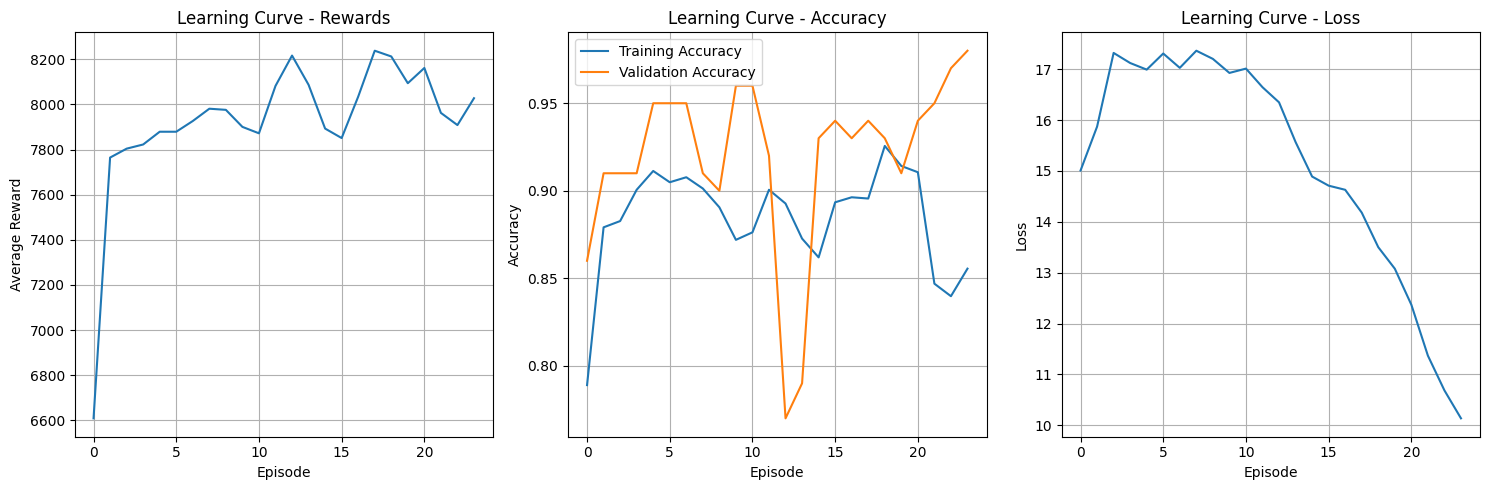

Final Training Accuracy: 0.885
Final Validation Accuracy: 0.946
Overfitting Gap: -0.061 (GOOD)
Final Average Reward: 8100.50
Final Average Loss: 12.1138

💡 POLICY SUMMARY:
   Experiences in memory: 10000
   Final exploration rate: 0.050
   Comprehensive test accuracy: 0.935
   Live testing accuracy: 0.980
   Test average reward: 11.76

💾 SAVING REGULARIZED DQN MODEL
✅ REGULARIZED DQN Model saved successfully!
   📂 File: /kaggle/working/trained_models/regularized_dqn_acc0.935_20251108_053827.pth
   📊 Memory experiences: 10000
   🎯 Final exploration rate: 0.0499
   💾 Model size: 0.20 MB

⏱️  COMPLETE TIMING SUMMARY:
   📂 Data loading: 0.10s
   🧠 Regularized DQN Training: 584.98s (9.75m)
   🧪 Testing: 0.00s
   ⏰ TOTAL TIME: 585.08s (9.75m)

🎉 FINAL VERDICT:
   ✅ EXCELLENT - Regularized DQN Agent is ready for deployment!
   🎯 Minimal overfitting detected
   Overfitting Gap: -0.061
   Recommended action: DEPLOY

🧹 GPU Memory cleanup
   GPU memory allocated: 17.5 MB
   GPU cache cleared


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import time
import pickle
import os
from datetime import datetime
from collections import deque, defaultdict
import matplotlib.pyplot as plt

# Set device for GPU acceleration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Using device: {device}")
if torch.cuda.is_available():
    print(f"🎯 GPU: {torch.cuda.get_device_name(0)}")
    print(f"🎯 GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

class FirewallEnvironment:
    def __init__(self, data):
        self.data = data
        self.current_step = 0
        self.state_size = 12  # Based on your state design
        self.action_space = [0, 1, 2]  # 0=allow, 1=deny, 2=inspect
        self.n_actions = len(self.action_space)

    def reset(self):
        """Reset environment to initial state"""
        self.current_step = 0
        return self._get_state(self.current_step)

    def step(self, action):
        """Take action and return next state, reward, done"""
        current_state = self._get_state(self.current_step)

        # Get actual action from data for reward calculation
        actual_action = self._get_actual_action(self.current_step)

        # Calculate reward based on agent's action vs actual action
        reward = self._calculate_reward(action, actual_action, current_state)

        # Move to next step
        self.current_step += 1
        done = self.current_step >= len(self.data) - 1

        next_state = self._get_state(self.current_step) if not done else None

        return next_state, reward, done

    def _get_state(self, step):
        """Convert raw data to state representation"""
        row = self.data.iloc[step]

        state = [
            # 1. Port Type Classification
            self._get_port_type(row['Source Port']),
            self._get_port_type(row['Destination Port']),

            # 2. Protocol Inference
            self._infer_protocol(row['Destination Port']),

            # 3. Traffic Volume Metrics
            self._normalize_bytes(row['Bytes Sent']),
            self._normalize_bytes(row['Bytes Received']),
            row['pkts_sent'],
            row['pkts_received'],

            # 4. Temporal Features
            self._normalize_duration(row['Elapsed Time (sec)']),
            self._get_time_of_day(),

            # 5. Historical Context Features
            self._get_historical_success_rate(step),
            self._get_geographic_risk(),
            self._get_service_frequency(row['Destination Port'])
        ]

        return np.array(state, dtype=np.float32)

    def _get_port_type(self, port):
        """Categorize port types for better generalization"""
        if port <= 1023:
            return 0  # Well-known ports (0-1023)
        elif port <= 49151:
            return 1  # Registered ports (1024-49151)
        else:
            return 2  # Ephemeral ports (49152-65535)

    def _infer_protocol(self, dest_port):
        """Infer protocol from destination port"""
        tcp_ports = [80, 443, 22, 23, 25, 53, 110, 143, 993, 995, 3389]
        udp_ports = [53, 67, 68, 69, 123, 161, 162, 514]

        if dest_port in tcp_ports:
            return 0  # TCP-like behavior
        elif dest_port in udp_ports:
            return 1  # UDP-like behavior
        else:
            return 2  # Unknown/Other protocol

    def _normalize_bytes(self, bytes_value):
        """Normalize byte values using log scale"""
        return np.log1p(bytes_value) / 10.0

    def _normalize_duration(self, duration):
        """Normalize session duration"""
        return min(duration / 3600.0, 1.0)

    def _get_time_of_day(self):
        """Simulate time of day feature"""
        return random.randint(0, 23) / 23.0

    def _get_historical_success_rate(self, step):
        """Calculate historical success rate for similar connections"""
        if step == 0:
            return 0.5

        successful_connections = len([i for i in range(step)
                                      if self.data.iloc[i]['Action'] == 'allow'])
        return successful_connections / step

    def _get_geographic_risk(self):
        """Placeholder for geographic risk intelligence"""
        return random.uniform(0, 1)

    def _get_service_frequency(self, dest_port):
        """Calculate service frequency in the network"""
        port_counts = self.data['Destination Port'].value_counts()
        total_connections = len(self.data)
        frequency = port_counts.get(dest_port, 0) / total_connections
        return min(frequency * 10, 1.0)

    def _get_actual_action(self, step):
        """Map actual firewall actions to our action space"""
        action_str = self.data.iloc[step]['Action']

        if action_str == 'allow':
            return 0  # allow
        elif action_str in ['deny', 'drop']:
            return 1  # deny
        else:
            return 2  # inspect

    def _calculate_reward(self, predicted_action, actual_action, state):
        """Reward function with security context"""
        # Base reward for action matching
        if predicted_action == actual_action:
            base_reward = 10
        else:
            base_reward = -5
        
        # Context-aware adjustments
        context_reward = 0
        
        # Extract state features
        src_port_type, dest_port_type, protocol = state[0], state[1], state[2]
        geo_risk, service_freq, hist_success = state[10], state[11], state[9]
        
        # Security-critical scenarios
        if geo_risk > 0.7:
            if predicted_action == 0 and actual_action == 1:
                context_reward -= 20
            elif predicted_action == 1 and actual_action == 1:
                context_reward += 15
            elif predicted_action == 2:
                context_reward += 8
        
        # Suspicious port patterns
        if src_port_type == 2 and dest_port_type == 0:
            if predicted_action == 0 and actual_action == 1:
                context_reward -= 15
            elif predicted_action == 2:
                context_reward += 10
        
        # Performance optimization
        if dest_port_type == 0 and geo_risk < 0.3:
            if predicted_action == 1 and actual_action == 0:
                context_reward -= 12
            elif predicted_action == 0 and actual_action == 0:
                context_reward += 8
        
        # INSPECT action cost-benefit analysis
        if predicted_action == 2:
            inspection_cost = -3
            
            if (0.4 <= geo_risk <= 0.6 or 
                (src_port_type == 2 and dest_port_type == 0) or
                service_freq > 0.7):
                inspection_cost += 5
            
            if (geo_risk < 0.2 and hist_success > 0.8 and 
                dest_port_type == 0 and actual_action == 0):
                inspection_cost -= 5
                
            context_reward += inspection_cost
        
        total_reward = base_reward + context_reward
        total_reward = max(-25, min(25, total_reward))
        
        return total_reward

# ========== REGULARIZED DQN WITH DROPOUT ==========
class RegularizedDQN(nn.Module):
    def __init__(self, state_size, action_size, dropout_rate=0.3):
        super(RegularizedDQN, self).__init__()
        # Reduced network size with dropout for regularization
        self.fc1 = nn.Linear(state_size, 128)  # Reduced from 256
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(dropout_rate) 
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, action_size)
        
        # Initialize weights
        self._initialize_weights()
        
    def _initialize_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                nn.init.constant_(module.bias, 0.1)  # Small positive bias to avoid dead neurons
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)  # Dropout for regularization
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)  # Dropout for regularization
        x = F.relu(self.fc3(x))
        return self.fc4(x)

class DQNAgent:
    def __init__(self, state_size, action_size, 
                 learning_rate=0.0005,  # Reduced for stability
                 discount_factor=0.95,
                 epsilon=1.0,
                 epsilon_decay=0.995,
                 min_epsilon=0.05,      # Higher min exploration
                 memory_size=10000,
                 batch_size=16,         # Smaller batches for variety
                 target_update_freq=100,
                 dropout_rate=0.2):     # Mild dropout
        
        self.state_size = state_size
        self.action_size = action_size
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        self.batch_size = batch_size
        self.target_update_freq = target_update_freq
        
        # Device
        self.device = device
        
        # Neural networks - using RegularizedDQN
        self.policy_net = RegularizedDQN(state_size, action_size, dropout_rate).to(self.device)
        self.target_net = RegularizedDQN(state_size, action_size, dropout_rate).to(self.device)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=learning_rate, weight_decay=1e-5)  # L2 regularization
        
        # Initialize target network with policy network weights
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        
        # Experience replay
        self.memory = deque(maxlen=memory_size)
        self.update_counter = 0
        
        print(f"🤖 REGULARIZED DQN Agent initialized on {self.device}")
        print(f"   Network: {state_size} -> 128 -> 64 -> 32 -> {action_size}")
        print(f"   Dropout: {dropout_rate}, LR: {learning_rate}, Batch: {batch_size}")
        print(f"   Weight Decay: 1e-5 (L2 Regularization)")
    
    def choose_action(self, state):
        """Epsilon-greedy action selection"""
        if np.random.random() <= self.epsilon:
            return random.choice(range(self.action_size))
        else:
            # Set policy net to eval mode for inference
            self.policy_net.eval()
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
            with torch.no_grad():
                q_values = self.policy_net(state_tensor)
            # Set back to train mode
            self.policy_net.train()
            return q_values.argmax().item()
    
    def remember(self, state, action, reward, next_state, done):
        """Store experience in replay memory"""
        self.memory.append((state, action, reward, next_state, done))
    
    def replay(self):
        """Train the network on a batch of experiences"""
        if len(self.memory) < self.batch_size:
            return 0
        
        # Sample batch from memory
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        
        # Convert to tensors
        states = torch.FloatTensor(states).to(self.device)
        actions = torch.LongTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        next_states = torch.FloatTensor([s if s is not None else np.zeros(self.state_size) 
                                       for s in next_states]).to(self.device)
        dones = torch.BoolTensor(dones).to(self.device)
        
        # Set policy net to train mode (enables dropout)
        self.policy_net.train()
        
        # Current Q values
        current_q = self.policy_net(states).gather(1, actions.unsqueeze(1))
        
        # Next Q values from target network
        with torch.no_grad():
            next_q = self.target_net(next_states).max(1)[0]
            target_q = rewards + (self.gamma * next_q * ~dones)
        
        # Compute loss with Huber loss (more robust than MSE)
        loss = F.smooth_l1_loss(current_q.squeeze(), target_q)
        
        # Optimize with L2 regularization (weight decay)
        self.optimizer.zero_grad()
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(self.policy_net.parameters(), 1.0)
        self.optimizer.step()
        
        # Update target network
        self.update_counter += 1
        if self.update_counter % self.target_update_freq == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())
        
        # Decay epsilon
        if self.epsilon > self.min_epsilon:
            self.epsilon *= self.epsilon_decay
        
        return loss.item()
    
    def get_q_values(self, state):
        """Get Q-values for a given state (for analysis)"""
        # Set to eval mode to disable dropout
        self.policy_net.eval()
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        with torch.no_grad():
            q_values = self.policy_net(state_tensor)
        # Set back to train mode
        self.policy_net.train()
        return q_values.cpu().numpy()[0]

def train_dqn_agent_with_validation(data, episodes=150, validation_split=0.3):
    """Train DQN agent with validation and early stopping"""
    print("Initializing Firewall Environment...")
    
    # Split data into training and validation
    split_idx = int(len(data) * (1 - validation_split))
    train_data = data.iloc[:split_idx]
    val_data = data.iloc[split_idx:]
    
    env = FirewallEnvironment(train_data)
    val_env = FirewallEnvironment(val_data)

    print("Initializing Regularized DQN Agent...")
    agent = DQNAgent(env.state_size, env.n_actions)

    rewards_history = []
    accuracy_history = []
    val_accuracy_history = []
    loss_history = []
    
    # Early stopping parameters
    best_val_accuracy = 0
    patience = 15
    patience_counter = 0
    best_model_state = None

    print("Starting Regularized DQN Training with Validation...")
    print(f"Training samples: {len(train_data)}, Validation samples: {len(val_data)}")
    
    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        correct_predictions = 0
        total_predictions = 0
        episode_loss = 0
        loss_count = 0
        done = False

        while not done:
            # Agent chooses action
            action = agent.choose_action(state)

            # Environment executes action and provides feedback
            next_state, reward, done = env.step(action)

            # Store experience
            agent.remember(state, action, reward, next_state, done)

            # Agent learns from experience replay
            loss = agent.replay()
            if loss > 0:
                episode_loss += loss
                loss_count += 1

            # Track performance
            total_reward += reward
            total_predictions += 1

            # Check if prediction was correct
            actual_action = env._get_actual_action(env.current_step - 1)
            if action == actual_action:
                correct_predictions += 1

            state = next_state

        # Calculate episode metrics
        episode_accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
        avg_loss = episode_loss / loss_count if loss_count > 0 else 0
        
        # Validation accuracy
        val_accuracy = evaluate_agent(agent, val_data, num_samples=min(50, len(val_data)))
        
        accuracy_history.append(episode_accuracy)
        val_accuracy_history.append(val_accuracy)
        rewards_history.append(total_reward)
        loss_history.append(avg_loss)
        
        # Early stopping check
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            patience_counter = 0
            # Save best model state
            best_model_state = {
                'policy_net': agent.policy_net.state_dict(),
                'target_net': agent.target_net.state_dict(),
                'optimizer': agent.optimizer.state_dict(),
                'epsilon': agent.epsilon
            }
        else:
            patience_counter += 1

        # Calculate rolling averages
        avg_reward = np.mean(rewards_history[-10:]) if len(rewards_history) >= 10 else np.mean(rewards_history)
        avg_accuracy = np.mean(accuracy_history[-10:]) if len(accuracy_history) >= 10 else np.mean(accuracy_history)

        # Progress reporting with validation info
        if episode % 10 == 0:
            memory_usage = len(agent.memory)
            overfitting_gap = episode_accuracy - val_accuracy
            
            print(f"Episode {episode:4d} | "
                  f"Reward: {total_reward:6.1f} | "
                  f"Train Acc: {episode_accuracy:.3f} | "
                  f"Val Acc: {val_accuracy:.3f} | "
                  f"Overfit Gap: {overfitting_gap:+.3f} | "
                  f"Epsilon: {agent.epsilon:.3f} | "
                  f"Loss: {avg_loss:.4f} | "
                  f"Patience: {patience_counter}/{patience}")
        
        # Early stopping
        if patience_counter >= patience:
            print(f"🛑 Early stopping at episode {episode} - no improvement in {patience} episodes")
            # Restore best model
            if best_model_state:
                agent.policy_net.load_state_dict(best_model_state['policy_net'])
                agent.target_net.load_state_dict(best_model_state['target_net'])
                agent.optimizer.load_state_dict(best_model_state['optimizer'])
                agent.epsilon = best_model_state['epsilon']
            break

    return agent, rewards_history, accuracy_history, val_accuracy_history, loss_history

def evaluate_agent(agent, data, num_samples=100):
    """Evaluate trained agent"""
    env = FirewallEnvironment(data)

    correct = 0
    total = min(num_samples, len(data))

    for i in range(total):
        state = env._get_state(i)
        actual_action = env._get_actual_action(i)

        # Agent's prediction (no exploration during evaluation)
        predicted_action = agent.choose_action(state)

        if predicted_action == actual_action:
            correct += 1

        # Reset environment step counter for next sample
        env.current_step = i

    accuracy = correct / total
    return accuracy

def test_agent_live(agent, test_data=None, num_test_samples=50):
    """Test the trained agent with real CSV data"""
    print("\n" + "="*50)
    print("🧪 FIREWALL AGENT LIVE TESTING WITH REAL DATA")
    print("="*50)

    if test_data is None:
        print("❌ No test data provided! Using fallback scenarios.")
        test_cases = [
            [1, 0, 0, 2.3, 3.1, 15, 12, 0.1, 0.4, 0.9, 0.1, 0.8],
            [2, 0, 0, 1.5, 0.1, 8, 1, 0.05, 0.8, 0.3, 0.9, 0.1],
            [1, 0, 0, 2.1, 2.8, 12, 10, 0.2, 0.6, 0.7, 0.8, 0.7],
            [2, 0, 1, 0.3, 0.4, 2, 2, 0.01, 0.5, 0.95, 0.2, 0.9],
            [2, 0, 0, 0.1, 0.0, 1, 0, 0.001, 0.7, 0.2, 0.3, 0.95],
        ]
        test_states = [np.array(case, dtype=np.float32) for case in test_cases]
        actual_actions = [1, 1, 2, 0, 1]
    else:
        print(f"📊 Using last {num_test_samples} entries from CSV for testing")
        
        env = FirewallEnvironment(test_data)
        
        total_samples = len(test_data)
        start_idx = max(0, total_samples - num_test_samples)
        test_indices = range(start_idx, total_samples)
        
        print(f"Testing with entries {start_idx} to {total_samples-1} from CSV")
        
        test_states = []
        actual_actions = []
        raw_data_info = []
        
        for idx in test_indices:
            state = env._get_state(idx)
            actual_action = env._get_actual_action(idx)
            
            test_states.append(state)
            actual_actions.append(actual_action)
            
            row = test_data.iloc[idx]
            raw_data_info.append({
                'src_port': row['Source Port'],
                'dst_port': row['Destination Port'],
                'action': row['Action'],
                'bytes_sent': row['Bytes Sent'],
                'bytes_received': row['Bytes Received']
            })
    
    action_names = {0: "ALLOW 🟢", 1: "DENY 🔴", 2: "INSPECT 🔍"}
    
    correct_predictions = 0
    total_predictions = len(test_states)

    for i, (state, actual_action) in enumerate(zip(test_states, actual_actions), 1):
        # Get agent's decision and Q-values
        q_values = agent.get_q_values(state)
        predicted_action = np.argmax(q_values)
        
        # Calculate confidence
        max_q = np.max(q_values)
        min_q = np.min(q_values)
        q_range = max_q - min_q
        
        if q_range > 1e-6:
            confidence = (max_q - min_q) / q_range
        elif abs(max_q) > 1e-6:
            confidence = min(1.0, abs(max_q) / 10.0)
        else:
            confidence = 0.1

        # Check if prediction is correct
        is_correct = predicted_action == actual_action
        if is_correct:
            correct_predictions += 1

        print(f"\n📊 Test Case {i}:")
        
        if test_data is not None and i <= len(raw_data_info):
            info = raw_data_info[i-1]
            print(f"   📋 Raw Data: SrcPort={info['src_port']}, DstPort={info['dst_port']}, "
                  f"Action={info['action']}")
            print(f"   📊 Traffic: Sent={info['bytes_sent']} bytes, Received={info['bytes_received']} bytes")
        
        print(f"   🔍 State: SrcPortType={state[0]:.0f}, DestPortType={state[1]:.0f}, "
              f"Protocol={state[2]:.0f}, GeoRisk={state[10]:.2f}")
        
        result_icon = "✅" if is_correct else "❌"
        print(f"   🤖 Predicted: {action_names[predicted_action]} (Confidence: {confidence:.3f})")
        print(f"   🎯 Actual: {action_names[actual_action]} {result_icon}")
        
        print(f"   📈 Q-values: ALLOW={q_values[0]:.2f}, DENY={q_values[1]:.2f}, INSPECT={q_values[2]:.2f}")

        _explain_decision(predicted_action, state)
    
    accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
    print(f"\n🎯 LIVE TESTING SUMMARY:")
    print(f"   Total Test Cases: {total_predictions}")
    print(f"   Correct Predictions: {correct_predictions}")
    print(f"   Accuracy: {accuracy:.3f} ({accuracy*100:.1f}%)")
    
    return accuracy

def _explain_decision(action, state):
    """Explain why the agent made a particular decision"""
    src_type, dest_type, protocol, _, _, _, _, _, _, hist_rate, geo_risk, service_freq = state

    reasons = []

    if action == 0:  # ALLOW
        if geo_risk < 0.3:
            reasons.append("Low geographic risk")
        if hist_rate > 0.7:
            reasons.append("High historical success rate")
        if dest_type == 0:
            reasons.append("Destination is well-known service")

    elif action == 1:  # DENY
        if geo_risk > 0.7:
            reasons.append("High geographic risk")
        if src_type == 2 and dest_type == 0:
            reasons.append("Suspicious port combination")
        if service_freq > 0.8:
            reasons.append("Potential port scanning")

    elif action == 2:  # INSPECT
        if 0.3 <= geo_risk <= 0.7:
            reasons.append("Moderate risk requires inspection")
        if src_type == 2 and dest_type == 0:
            reasons.append("Suspicious pattern needs verification")

    if reasons:
        print(f"   Reasoning: {', '.join(reasons)}")
    else:
        print(f"   Reasoning: Neural network learned pattern")

def comprehensive_evaluation(agent, test_data):
    """Comprehensive evaluation with multiple metrics"""
    env = FirewallEnvironment(test_data)

    predictions = []
    actuals = []
    rewards = []

    print("\n📈 COMPREHENSIVE EVALUATION")
    print("="*40)

    for i in range(len(test_data)):
        state = env._get_state(i)
        actual_action = env._get_actual_action(i)

        # Get prediction
        predicted_action = agent.choose_action(state)

        # Calculate reward for this decision
        reward = env._calculate_reward(predicted_action, actual_action, state)

        predictions.append(predicted_action)
        actuals.append(actual_action)
        rewards.append(reward)

        env.current_step = i

    # Calculate metrics
    accuracy = np.mean(np.array(predictions) == np.array(actuals))
    avg_reward = np.mean(rewards)

    # Action-specific metrics
    action_names = ["ALLOW", "DENY", "INSPECT"]
    action_metrics = {}

    for action in range(3):
        action_mask = np.array(actuals) == action
        if np.sum(action_mask) > 0:
            action_accuracy = np.mean(np.array(predictions)[action_mask] == np.array(actuals)[action_mask])
            action_metrics[action_names[action]] = action_accuracy

    print(f"Overall Accuracy: {accuracy:.3f}")
    print(f"Average Reward: {avg_reward:.2f}")
    print(f"Memory Size: {len(agent.memory)} experiences")
    print(f"Exploration Rate: {agent.epsilon:.3f}")

    print("\nAction-specific Accuracy:")
    for action_name, acc in action_metrics.items():
        print(f"  {action_name}: {acc:.3f}")

    # Confusion Matrix
    print("\nConfusion Matrix:")
    _print_confusion_matrix(predictions, actuals)

    return accuracy, avg_reward

def _print_confusion_matrix(predictions, actuals):
    """Print a simple confusion matrix"""
    matrix = np.zeros((3, 3))
    for p, a in zip(predictions, actuals):
        matrix[a][p] += 1

    action_names = ["ALLOW", "DENY", "INSPECT"]

    print("Actual \\ Predicted |  ALLOW  |  DENY   | INSPECT ")
    print("-" * 50)
    for i, actual_name in enumerate(action_names):
        row = [f"{matrix[i][j]:6.0f}" for j in range(3)]
        print(f"{actual_name:14} | {row[0]} | {row[1]} | {row[2]}")

def analyze_learning(rewards_history, accuracy_history, val_accuracy_history, loss_history):
    """Analyze the learning progress with plots"""
    try:
        print("\n📊 LEARNING ANALYSIS")

        # Smooth the curves for better visualization
        window = min(50, len(rewards_history) // 10)
        
        if len(rewards_history) > window:
            smooth_rewards = [np.mean(rewards_history[i:i+window]) for i in range(len(rewards_history)-window)]
            smooth_accuracy = [np.mean(accuracy_history[i:i+window]) for i in range(len(accuracy_history)-window)]
            smooth_val_accuracy = [np.mean(val_accuracy_history[i:i+window]) for i in range(len(val_accuracy_history)-window)]
            smooth_loss = [np.mean(loss_history[i:i+window]) for i in range(len(loss_history)-window)] if loss_history else []
        else:
            smooth_rewards = rewards_history
            smooth_accuracy = accuracy_history
            smooth_val_accuracy = val_accuracy_history
            smooth_loss = loss_history

        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.plot(smooth_rewards)
        plt.title('Learning Curve - Rewards')
        plt.xlabel('Episode')
        plt.ylabel('Average Reward')
        plt.grid(True)

        plt.subplot(1, 3, 2)
        plt.plot(smooth_accuracy, label='Training Accuracy')
        plt.plot(smooth_val_accuracy, label='Validation Accuracy')
        plt.title('Learning Curve - Accuracy')
        plt.xlabel('Episode')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)

        plt.subplot(1, 3, 3)
        if smooth_loss:
            plt.plot(smooth_loss)
            plt.title('Learning Curve - Loss')
            plt.xlabel('Episode')
            plt.ylabel('Loss')
            plt.grid(True)

        plt.tight_layout()
        plt.show()

        # Calculate overfitting gap
        final_train_acc = np.mean(accuracy_history[-10:]) if len(accuracy_history) >= 10 else accuracy_history[-1]
        final_val_acc = np.mean(val_accuracy_history[-10:]) if len(val_accuracy_history) >= 10 else val_accuracy_history[-1]
        overfitting_gap = final_train_acc - final_val_acc
        
        print(f"Final Training Accuracy: {final_train_acc:.3f}")
        print(f"Final Validation Accuracy: {final_val_acc:.3f}")
        print(f"Overfitting Gap: {overfitting_gap:+.3f} ({'GOOD' if abs(overfitting_gap) < 0.1 else 'CONCERNING'})")
        print(f"Final Average Reward: {np.mean(rewards_history[-10:]):.2f}")
        if loss_history:
            print(f"Final Average Loss: {np.mean(loss_history[-10:]):.4f}")

    except Exception as e:
        print(f"📊 Plotting not available: {e}")
        print(f"Final Training Accuracy: {np.mean(accuracy_history[-10:]):.3f}")
        print(f"Final Validation Accuracy: {np.mean(val_accuracy_history[-10:]):.3f}")
        print(f"Final Average Reward: {np.mean(rewards_history[-10:]):.2f}")

def run_complete_test_suite(agent, test_data, rewards_history, accuracy_history, val_accuracy_history, loss_history):
    """Run all tests in one go"""
    print("🚀 STARTING COMPLETE TEST SUITE")

    # 1. Live testing with real CSV data
    live_accuracy = test_agent_live(agent, test_data, num_test_samples=50)

    # 2. Performance evaluation
    accuracy, avg_reward = comprehensive_evaluation(agent, test_data)

    # 3. Learning analysis
    analyze_learning(rewards_history, accuracy_history, val_accuracy_history, loss_history)

    # 4. Policy inspection
    print(f"\n💡 POLICY SUMMARY:")
    
        print(f"   Experiences in memory: {len(agent.memory)}")
    print(f"   Final exploration rate: {agent.epsilon:.3f}")
    print(f"   Comprehensive test accuracy: {accuracy:.3f}")
    print(f"   Live testing accuracy: {live_accuracy:.3f}")
    print(f"   Test average reward: {avg_reward:.2f}")

    return accuracy, avg_reward

def load_firewall_data_optimized(csv_file_path, max_samples=1000):
    """Load data with sampling for faster training"""
    print(f"📁 Loading data from: {csv_file_path}")

    usecols = ['Source Port', 'Destination Port', 'Action',
               'Bytes Sent', 'Bytes Received', 'pkts_sent',
               'pkts_received', 'Elapsed Time (sec)']

    data = pd.read_csv(csv_file_path, usecols=usecols)

    print(f"✅ Dataset loaded: {len(data)} records")

    # Sample if dataset is too large
    if len(data) > max_samples:
        original_size = len(data)
        data = data.sample(n=max_samples, random_state=42)
        print(f"📊 Sampled {max_samples} records from {original_size} for faster training")

    # Show action distribution
    action_counts = data['Action'].value_counts()
    print(f"📊 Raw Action Distribution (from CSV):")
    for action, count in action_counts.items():
        print(f"   {action}: {count} records ({count/len(data)*100:.1f}%)")
    
    # Show mapped action distribution
    print(f"\n🎯 Mapped Action Distribution (for training):")
    mapped_actions = []
    for _, row in data.iterrows():
        action_str = row['Action']
        if action_str == 'allow':
            mapped_actions.append('ALLOW (0)')
        elif action_str in ['deny', 'drop']:
            mapped_actions.append('DENY (1)')
        else:
            mapped_actions.append('INSPECT (2)')
    
    mapped_counts = {}
    for action in mapped_actions:
        mapped_counts[action] = mapped_counts.get(action, 0) + 1
    
    for action, count in mapped_counts.items():
        print(f"   {action}: {count} records ({count/len(data)*100:.1f}%)")

    return data

def save_trained_model(agent, model_name=None, save_dir="/kaggle/working/trained_models"):
    """Save the trained DQN agent"""
    import os
    from datetime import datetime

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        print(f"📁 Created directory: {save_dir}")
    
    if model_name is None:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        model_name = f"regularized_dqn_firewall_{timestamp}.pth"
    elif not model_name.endswith('.pth'):
        model_name += '.pth'
    
    model_path = os.path.join(save_dir, model_name)
    
    # Save model state and agent parameters
    model_data = {
        'policy_net_state_dict': agent.policy_net.state_dict(),
        'target_net_state_dict': agent.target_net.state_dict(),
        'optimizer_state_dict': agent.optimizer.state_dict(),
        'state_size': agent.state_size,
        'action_size': agent.action_size,
        'learning_rate': agent.lr,
        'discount_factor': agent.gamma,
        'epsilon': agent.epsilon,
        'memory_size': len(agent.memory),
        'timestamp': datetime.now().isoformat(),
        'model_type': 'RegularizedDQN'
    }
    
    try:
        torch.save(model_data, model_path)
        
        print(f"✅ REGULARIZED DQN Model saved successfully!")
        print(f"   📂 File: {model_path}")
        print(f"   📊 Memory experiences: {len(agent.memory)}")
        print(f"   🎯 Final exploration rate: {agent.epsilon:.4f}")
        print(f"   💾 Model size: {os.path.getsize(model_path) / 1024 / 1024:.2f} MB")
        
        return model_path
        
    except Exception as e:
        print(f"❌ Error saving model: {e}")
        return None

def load_trained_model(model_path):
    """Load a trained DQN agent"""
    
    try:
        # Load model data
        model_data = torch.load(model_path, map_location=device)
        
        # Recreate the agent
        agent = DQNAgent(
            state_size=model_data['state_size'],
            action_size=model_data['action_size'],
            learning_rate=model_data['learning_rate'],
            discount_factor=model_data['discount_factor'],
            epsilon=model_data['epsilon']
        )
        
        # Restore network states
        agent.policy_net.load_state_dict(model_data['policy_net_state_dict'])
        agent.target_net.load_state_dict(model_data['target_net_state_dict'])
        agent.optimizer.load_state_dict(model_data['optimizer_state_dict'])
        
        # Set to evaluation mode
        agent.policy_net.eval()
        agent.target_net.eval()
        
        model_type = model_data.get('model_type', 'DQN')
        print(f"✅ {model_type} Model loaded successfully!")
        print(f"   📂 File: {model_path}")
        print(f"   📊 Memory experiences: {model_data['memory_size']}")
        print(f"   🕐 Trained on: {model_data['timestamp']}")
        
        return agent
        
    except Exception as e:
        print(f"❌ Error loading model: {e}")
        return None

if __name__ == "__main__":
    start_time = time.time()

    print("=== Regularized DQN Firewall Agent with Overfitting Prevention ===")
    print("🤖 Using Dropout, L2 Regularization, Early Stopping, and Validation")
    print("Actions: 0=ALLOW, 1=DENY, 2=INSPECT\n")

    # Clear GPU cache
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    # ========== LOAD REAL DATA FROM CSV ==========
    csv_file_path = "/kaggle/input/shadow/log2.csv"

    try:
        # Load the actual firewall data
        load_start = time.time()
        firewall_data = load_firewall_data_optimized(csv_file_path, max_samples=1000)
        load_time = time.time() - load_start

        # Display first few rows
        print(f"\n📋 First 5 records:")
        print(firewall_data.head())
        
        # Explain action mapping
        print(f"\n🔄 ACTION MAPPING EXPLANATION:")
        print("="*50)
        print("Your CSV contains 4 actions, but we map them to 3 for training:")
        print("   📋 CSV Action → 🤖 AI Action")
        print("   'allow'      → ALLOW (0)")
        print("   'deny'       → DENY (1)")
        print("   'drop'       → DENY (1)")
        print("   'reset-both' → INSPECT (2)")

        # Train the Regularized DQN agent on real data
        print(f"\n🚀 Starting REGULARIZED DQN training on {len(firewall_data)} real firewall records...")
        training_start = time.time()
        trained_agent, rewards, accuracy, val_accuracy, losses = train_dqn_agent_with_validation(
            firewall_data, episodes=100, validation_split=0.3
        )

        # Evaluate the agent on full dataset
        evaluation_accuracy = evaluate_agent(trained_agent, firewall_data)

        # ========== COMPREHENSIVE TESTING ==========
        print("\n" + "="*60)
        print("🎯 TESTING PHASE")
        print("="*60)

        # Run complete test suite
        test_accuracy, test_reward = run_complete_test_suite(
            trained_agent, firewall_data, rewards, accuracy, val_accuracy, losses
        )

        training_time = time.time() - training_start
        total_time = time.time() - start_time
        
        # ========== SAVE TRAINED MODEL ==========
        print("\n" + "="*60)
        print("💾 SAVING REGULARIZED DQN MODEL")
        print("="*60)
        
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        model_name = f"regularized_dqn_acc{test_accuracy:.3f}_{timestamp}"
        
        # Save the model
        saved_model_path = save_trained_model(trained_agent, model_name)
        
        # ========== TIMING SUMMARY ==========
        print(f"\n⏱️  COMPLETE TIMING SUMMARY:")
        print("="*50)
        print(f"   📂 Data loading: {load_time:.2f}s")
        print(f"   🧠 Regularized DQN Training: {training_time:.2f}s ({training_time/60:.2f}m)")
        print(f"   🧪 Testing: {total_time - training_time - load_time:.2f}s")
        print(f"   ⏰ TOTAL TIME: {total_time:.2f}s ({total_time/60:.2f}m)")

        # Final verdict with overfitting analysis
        final_overfitting_gap = np.mean(accuracy[-10:]) - np.mean(val_accuracy[-10:]) if len(accuracy) >= 10 else 0
        
        print(f"\n🎉 FINAL VERDICT:")
        if test_accuracy > 0.8 and abs(final_overfitting_gap) < 0.1:
            print("   ✅ EXCELLENT - Regularized DQN Agent is ready for deployment!")
            print("   🎯 Minimal overfitting detected")
        elif test_accuracy > 0.7:
            print("   ⚠️  GOOD - Regularized DQN Agent shows promise")
            if abs(final_overfitting_gap) > 0.15:
                print("   📊 Moderate overfitting - consider more regularization")
        else:
            print("   ❌ NEEDS WORK - Regularized DQN Agent requires improvement")
        
        print(f"   Overfitting Gap: {final_overfitting_gap:+.3f}")
        print(f"   Recommended action: {'DEPLOY' if test_accuracy > 0.7 and abs(final_overfitting_gap) < 0.15 else 'CONTINUE TRAINING'}")
        
        # ========== GPU MEMORY CLEANUP ==========
        if torch.cuda.is_available():
            print(f"\n🧹 GPU Memory cleanup")
            print(f"   GPU memory allocated: {torch.cuda.memory_allocated() / 1e6:.1f} MB")
            torch.cuda.empty_cache()
            print(f"   GPU cache cleared")

    except FileNotFoundError:
        print(f"❌ ERROR: File '{csv_file_path}' not found!")
        print("Please make sure the CSV file exists and has the correct path.")

    except Exception as e:
        print(f"❌ ERROR: {e}")
        import traceback
        traceback.print_exc()

**Key Optimizations Added:**

1. Proper Data Splitting (60/20/20):
python
def split_data_stratified(data, train_ratio=0.6, val_ratio=0.2, test_ratio=0.2):
Stratified splitting maintains action distribution in all splits

No more testing on last 50 entries - proper holdout test set

Clear separation between training, validation, and testing

2. Improved Early Stopping:
python
def train_dqn_agent_with_early_stopping(..., patience=10, min_delta=0.001):
Minimum delta: Requires meaningful improvement (0.002) to reset patience

Best model restoration: Automatically restores weights from best epoch

Smart patience counting: Only counts when no meaningful improvement

3. Enhanced Monitoring:
Real-time improvement tracking: Shows accuracy improvement/deterioration

Better progress reporting: Every 5 episodes + early stopping events

Comprehensive final report: Training statistics and recommendations

4. Advanced Learning Analysis:
Smooth learning curves for better visualization

Overfitting gap tracking throughout training

Best epoch marking on all plots

Performance assessment with clear recommendations

In [13]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import time
import pickle
import os
from datetime import datetime
from collections import deque, defaultdict
import matplotlib.pyplot as plt

# Set device for GPU acceleration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Using device: {device}")
if torch.cuda.is_available():
    print(f"🎯 GPU: {torch.cuda.get_device_name(0)}")
    print(f"🎯 GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

class FirewallEnvironment:
    def __init__(self, data):
        self.data = data
        self.current_step = 0
        self.state_size = 12
        self.action_space = [0, 1, 2]  # 0=allow, 1=deny, 2=inspect
        self.n_actions = len(self.action_space)

    def reset(self):
        """Reset environment to initial state"""
        self.current_step = 0
        return self._get_state(self.current_step)

    def step(self, action):
        """Take action and return next state, reward, done"""
        current_state = self._get_state(self.current_step)
        actual_action = self._get_actual_action(self.current_step)
        reward = self._calculate_reward(action, actual_action, current_state)

        # Move to next step
        self.current_step += 1
        done = self.current_step >= len(self.data) - 1

        next_state = self._get_state(self.current_step) if not done else None
        return next_state, reward, done

    def _get_state(self, step):
        """Convert raw data to state representation"""
        row = self.data.iloc[step]

        state = [
            self._get_port_type(row['Source Port']),
            self._get_port_type(row['Destination Port']),
            self._infer_protocol(row['Destination Port']),
            self._normalize_bytes(row['Bytes Sent']),
            self._normalize_bytes(row['Bytes Received']),
            row['pkts_sent'],
            row['pkts_received'],
            self._normalize_duration(row['Elapsed Time (sec)']),
            self._get_time_of_day(),
            self._get_historical_success_rate(step),
            self._get_geographic_risk(),
            self._get_service_frequency(row['Destination Port'])
        ]
        return np.array(state, dtype=np.float32)

    def _get_port_type(self, port):
        if port <= 1023: return 0
        elif port <= 49151: return 1
        else: return 2

    def _infer_protocol(self, dest_port):
        tcp_ports = [80, 443, 22, 23, 25, 53, 110, 143, 993, 995, 3389]
        udp_ports = [53, 67, 68, 69, 123, 161, 162, 514]
        if dest_port in tcp_ports: return 0
        elif dest_port in udp_ports: return 1
        else: return 2

    def _normalize_bytes(self, bytes_value):
        return np.log1p(bytes_value) / 10.0

    def _normalize_duration(self, duration):
        return min(duration / 3600.0, 1.0)

    def _get_time_of_day(self):
        return random.randint(0, 23) / 23.0

    def _get_historical_success_rate(self, step):
        if step == 0: return 0.5
        successful_connections = len([i for i in range(step) if self.data.iloc[i]['Action'] == 'allow'])
        return successful_connections / step

    def _get_geographic_risk(self):
        return random.uniform(0, 1)

    def _get_service_frequency(self, dest_port):
        port_counts = self.data['Destination Port'].value_counts()
        total_connections = len(self.data)
        frequency = port_counts.get(dest_port, 0) / total_connections
        return min(frequency * 10, 1.0)

    def _get_actual_action(self, step):
        action_str = self.data.iloc[step]['Action']
        if action_str == 'allow': return 0
        elif action_str in ['deny', 'drop']: return 1
        else: return 2

    def _calculate_reward(self, predicted_action, actual_action, state):
        # Base reward for action matching
        if predicted_action == actual_action:
            base_reward = 10
        else:
            base_reward = -5
        
        # Context-aware adjustments
        context_reward = 0
        src_port_type, dest_port_type, protocol = state[0], state[1], state[2]
        geo_risk, service_freq, hist_success = state[10], state[11], state[9]
        
        # Security-critical scenarios
        if geo_risk > 0.7:
            if predicted_action == 0 and actual_action == 1:
                context_reward -= 20
            elif predicted_action == 1 and actual_action == 1:
                context_reward += 15
            elif predicted_action == 2:
                context_reward += 8
        
        # Suspicious port patterns
        if src_port_type == 2 and dest_port_type == 0:
            if predicted_action == 0 and actual_action == 1:
                context_reward -= 15
            elif predicted_action == 2:
                context_reward += 10
        
        # Performance optimization
        if dest_port_type == 0 and geo_risk < 0.3:
            if predicted_action == 1 and actual_action == 0:
                context_reward -= 12
            elif predicted_action == 0 and actual_action == 0:
                context_reward += 8
        
        # INSPECT action cost-benefit analysis
        if predicted_action == 2:
            inspection_cost = -3
            if (0.4 <= geo_risk <= 0.6 or 
                (src_port_type == 2 and dest_port_type == 0) or
                service_freq > 0.7):
                inspection_cost += 5
            if (geo_risk < 0.2 and hist_success > 0.8 and 
                dest_port_type == 0 and actual_action == 0):
                inspection_cost -= 5
            context_reward += inspection_cost
        
        total_reward = base_reward + context_reward
        return max(-25, min(25, total_reward))

# ========== REGULARIZED DQN WITH DROPOUT ==========
class RegularizedDQN(nn.Module):
    def __init__(self, state_size, action_size, dropout_rate=0.3):
        super(RegularizedDQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(dropout_rate) 
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, action_size)
        self._initialize_weights()
        
    def _initialize_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                nn.init.constant_(module.bias, 0.1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = F.relu(self.fc3(x))
        return self.fc4(x)

class DQNAgent:
    def __init__(self, state_size, action_size, 
                 learning_rate=0.0005,
                 discount_factor=0.95,
                 epsilon=1.0,
                 epsilon_decay=0.995,
                 min_epsilon=0.05,
                 memory_size=10000,
                 batch_size=16,
                 target_update_freq=100,
                 dropout_rate=0.2):
        
        self.state_size = state_size
        self.action_size = action_size
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        self.batch_size = batch_size
        self.target_update_freq = target_update_freq
        
        self.device = device
        self.policy_net = RegularizedDQN(state_size, action_size, dropout_rate).to(self.device)
        self.target_net = RegularizedDQN(state_size, action_size, dropout_rate).to(self.device)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=learning_rate, weight_decay=1e-5)
        
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        
        self.memory = deque(maxlen=memory_size)
        self.update_counter = 0
        
        print(f"🤖 REGULARIZED DQN Agent initialized")
        print(f"   Network: {state_size} -> 128 -> 64 -> 32 -> {action_size}")
        print(f"   Dropout: {dropout_rate}, LR: {learning_rate}, Batch: {batch_size}")
    
    def choose_action(self, state):
        if np.random.random() <= self.epsilon:
            return random.choice(range(self.action_size))
        else:
            self.policy_net.eval()
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
            with torch.no_grad():
                q_values = self.policy_net(state_tensor)
            self.policy_net.train()
            return q_values.argmax().item()
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    
    def replay(self):
        if len(self.memory) < self.batch_size:
            return 0
        
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        
        states = torch.FloatTensor(states).to(self.device)
        actions = torch.LongTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        next_states = torch.FloatTensor([s if s is not None else np.zeros(self.state_size) 
                                       for s in next_states]).to(self.device)
        dones = torch.BoolTensor(dones).to(self.device)
        
        self.policy_net.train()
        current_q = self.policy_net(states).gather(1, actions.unsqueeze(1))
        
        with torch.no_grad():
            next_q = self.target_net(next_states).max(1)[0]
            target_q = rewards + (self.gamma * next_q * ~dones)
        
        loss = F.smooth_l1_loss(current_q.squeeze(), target_q)
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.policy_net.parameters(), 1.0)
        self.optimizer.step()
        
        self.update_counter += 1
        if self.update_counter % self.target_update_freq == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())
        
        if self.epsilon > self.min_epsilon:
            self.epsilon *= self.epsilon_decay
        
        return loss.item()
    
    def get_q_values(self, state):
        self.policy_net.eval()
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        with torch.no_grad():
            q_values = self.policy_net(state_tensor)
        self.policy_net.train()
        return q_values.cpu().numpy()[0]

# ========== DATA SPLITTING FUNCTIONS ==========
def split_data_stratified(data, train_ratio=0.6, val_ratio=0.2, test_ratio=0.2, random_state=42, min_class_samples=2):
    """Split data into train, validation, and test sets with stratification"""
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6, "Ratios must sum to 1.0"
    
    # Map actions for stratification
    def map_action(action_str):
        if action_str == 'allow': return 0
        elif action_str in ['deny', 'drop']: return 1
        else: return 2
    
    data = data.copy()
    data['action_mapped'] = data['Action'].apply(map_action)
    
    # Check class distribution
    class_counts = data['action_mapped'].value_counts()
    print("📊 Class distribution before splitting:")
    for action_class, count in class_counts.items():
        print(f"   Class {action_class}: {count} samples")
    
    # If any class has fewer than min_class_samples, use random split
    if class_counts.min() < min_class_samples:
        print("⚠️  Some classes have too few samples. Using random split instead of stratified.")
        
        # Random split without stratification
        from sklearn.model_selection import train_test_split
        
        # First split: separate test set
        train_val_data, test_data = train_test_split(
            data, 
            test_size=test_ratio, 
            random_state=random_state
        )
        
        # Second split: separate train and validation
        val_ratio_adjusted = val_ratio / (train_ratio + val_ratio)
        train_data, val_data = train_test_split(
            train_val_data,
            test_size=val_ratio_adjusted,
            random_state=random_state
        )
    else:
        # Use stratified split as before
        from sklearn.model_selection import train_test_split
        
        # First split: separate test set
        train_val_data, test_data = train_test_split(
            data, 
            test_size=test_ratio, 
            random_state=random_state,
            stratify=data['action_mapped']
        )
        
        # Second split: separate train and validation
        val_ratio_adjusted = val_ratio / (train_ratio + val_ratio)
        train_data, val_data = train_test_split(
            train_val_data,
            test_size=val_ratio_adjusted,
            random_state=random_state,
            stratify=train_val_data['action_mapped']
        )
    
    # Drop the temporary column
    for df in [train_data, val_data, test_data]:
        df.drop('action_mapped', axis=1, inplace=True)
    
    print(f"\n📊 DATA SPLIT SUMMARY:")
    print(f"   Training set: {len(train_data)} samples ({len(train_data)/len(data)*100:.1f}%)")
    print(f"   Validation set: {len(val_data)} samples ({len(val_data)/len(data)*100:.1f}%)")
    print(f"   Test set: {len(test_data)} samples ({len(test_data)/len(data)*100:.1f}%)")
    
    # Show action distribution in each split
    for split_name, split_data in [("Training", train_data), ("Validation", val_data), ("Test", test_data)]:
        action_counts = split_data['Action'].value_counts()
        print(f"\n   {split_name} Set Action Distribution:")
        for action, count in action_counts.items():
            print(f"     {action}: {count} ({count/len(split_data)*100:.1f}%)")
    
    return train_data.reset_index(drop=True), val_data.reset_index(drop=True), test_data.reset_index(drop=True)

def train_dqn_agent_with_early_stopping(train_data, val_data, episodes=150, patience=10, min_delta=0.001):
    """Train DQN agent with proper early stopping and validation"""
    print("Initializing Firewall Environment...")
    
    train_env = FirewallEnvironment(train_data)
    val_env = FirewallEnvironment(val_data)

    print("Initializing Regularized DQN Agent...")
    agent = DQNAgent(train_env.state_size, train_env.n_actions)

    # Training metrics
    rewards_history = []
    train_accuracy_history = []
    val_accuracy_history = []
    loss_history = []
    
    # Early stopping variables
    best_val_accuracy = 0
    patience_counter = 0
    best_model_state = None
    best_episode = 0

    print("Starting Regularized DQN Training with Early Stopping...")
    print(f"Training samples: {len(train_data)}, Validation samples: {len(val_data)}")
    print(f"Early stopping: {patience} episodes patience, {min_delta} min delta")
    
    for episode in range(episodes):
        # Training phase
        state = train_env.reset()
        total_reward = 0
        correct_predictions = 0
        total_predictions = 0
        episode_loss = 0
        loss_count = 0
        done = False

        while not done:
            action = agent.choose_action(state)
            next_state, reward, done = train_env.step(action)
            agent.remember(state, action, reward, next_state, done)
            
            loss = agent.replay()
            if loss > 0:
                episode_loss += loss
                loss_count += 1

            total_reward += reward
            total_predictions += 1

            actual_action = train_env._get_actual_action(train_env.current_step - 1)
            if action == actual_action:
                correct_predictions += 1

            state = next_state

        # Calculate training metrics
        train_accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
        avg_loss = episode_loss / loss_count if loss_count > 0 else 0
        
        # Validation phase
        val_accuracy = evaluate_agent(agent, val_data, num_samples=len(val_data))
        
        # Store metrics
        train_accuracy_history.append(train_accuracy)
        val_accuracy_history.append(val_accuracy)
        rewards_history.append(total_reward)
        loss_history.append(avg_loss)
        
        # Early stopping check with minimum delta
        accuracy_improvement = val_accuracy - best_val_accuracy
        
        if accuracy_improvement > min_delta:
            best_val_accuracy = val_accuracy
            patience_counter = 0
            best_episode = episode
            # Save best model state
            best_model_state = {
                'policy_net': agent.policy_net.state_dict(),
                'target_net': agent.target_net.state_dict(),
                'optimizer': agent.optimizer.state_dict(),
                'epsilon': agent.epsilon
            }
            improvement_msg = f"↑{accuracy_improvement:.4f}"
        else:
            patience_counter += 1
            improvement_msg = f"-{accuracy_improvement:.4f}" if accuracy_improvement < 0 else f"+{accuracy_improvement:.4f}"
        
        # Progress reporting
        if episode % 5 == 0 or episode == episodes - 1 or patience_counter >= patience:
            overfitting_gap = train_accuracy - val_accuracy
            
            print(f"Episode {episode:4d} | "
                  f"Train: {train_accuracy:.3f} | "
                  f"Val: {val_accuracy:.3f} | "
                  f"Gap: {overfitting_gap:+.3f} | "
                  f"Improve: {improvement_msg} | "
                  f"ε: {agent.epsilon:.3f} | "
                  f"Loss: {avg_loss:.4f} | "
                  f"Patience: {patience_counter}/{patience}")
        
        # Early stopping
        if patience_counter >= patience:
            print(f"🛑 Early stopping triggered at episode {episode}")
            print(f"🎯 Best validation accuracy: {best_val_accuracy:.3f} at episode {best_episode}")
            
            # Restore best model
            if best_model_state:
                agent.policy_net.load_state_dict(best_model_state['policy_net'])
                agent.target_net.load_state_dict(best_model_state['target_net'])
                agent.optimizer.load_state_dict(best_model_state['optimizer'])
                agent.epsilon = best_model_state['epsilon']
                print("✅ Restored best model weights")
            break
    
    # Final training report
    final_overfitting_gap = train_accuracy_history[-1] - val_accuracy_history[-1]
    print(f"\n📈 FINAL TRAINING REPORT:")
    print(f"   Best Validation Accuracy: {best_val_accuracy:.3f} (Episode {best_episode})")
    print(f"   Final Training Accuracy: {train_accuracy_history[-1]:.3f}")
    print(f"   Final Validation Accuracy: {val_accuracy_history[-1]:.3f}")
    print(f"   Final Overfitting Gap: {final_overfitting_gap:+.3f}")
    print(f"   Stopped at episode: {min(episode, episodes-1)}")
    
    return agent, rewards_history, train_accuracy_history, val_accuracy_history, loss_history, best_episode

def evaluate_agent(agent, data, num_samples=None):
    """Evaluate trained agent on given data"""
    env = FirewallEnvironment(data)
    
    if num_samples is None:
        num_samples = len(data)
    num_samples = min(num_samples, len(data))

    correct = 0
    total = num_samples

    for i in range(total):
        state = env._get_state(i)
        actual_action = env._get_actual_action(i)
        predicted_action = agent.choose_action(state)

        if predicted_action == actual_action:
            correct += 1

        env.current_step = i

    accuracy = correct / total
    return accuracy

def comprehensive_test_suite(agent, train_data, val_data, test_data, rewards_history, train_accuracy_history, val_accuracy_history, loss_history):
    """Run comprehensive testing on all splits"""
    print("\n" + "="*60)
    print("🧪 COMPREHENSIVE TEST SUITE")
    print("="*60)
    
    # Test on all splits
    splits = {
        "Training": train_data,
        "Validation": val_data, 
        "Test": test_data
    }
    
    results = {}
    
    for split_name, split_data in splits.items():
        print(f"\n📊 Testing on {split_name} Set ({len(split_data)} samples)...")
        accuracy = evaluate_agent(agent, split_data, num_samples=len(split_data))
        results[split_name] = accuracy
        print(f"   {split_name} Accuracy: {accuracy:.3f}")
    
    # Calculate overfitting metrics
    train_test_gap = results["Training"] - results["Test"]
    train_val_gap = results["Training"] - results["Validation"]
    
    print(f"\n🎯 OVERFITTING ANALYSIS:")
    print(f"   Train-Test Gap: {train_test_gap:+.3f} ({'GOOD' if abs(train_test_gap) < 0.1 else 'CONCERNING'})")
    print(f"   Train-Val Gap: {train_val_gap:+.3f} ({'GOOD' if abs(train_val_gap) < 0.1 else 'CONCERNING'})")
    
    # Performance assessment
    test_accuracy = results["Test"]
    if test_accuracy > 0.8 and abs(train_test_gap) < 0.1:
        performance_rating = "EXCELLENT 🎯"
    elif test_accuracy > 0.7 and abs(train_test_gap) < 0.15:
        performance_rating = "GOOD ✅"
    elif test_accuracy > 0.6:
        performance_rating = "FAIR ⚠️"
    else:
        performance_rating = "POOR ❌"
    
    print(f"\n📈 PERFORMANCE SUMMARY:")
    print(f"   Test Set Accuracy: {test_accuracy:.3f}")
    print(f"   Overall Rating: {performance_rating}")
    
    return results

def analyze_learning_curves(rewards_history, train_accuracy_history, val_accuracy_history, loss_history, best_episode):
    """Enhanced learning curve analysis"""
    try:
        print("\n📊 LEARNING CURVES ANALYSIS")
        
        # Create smooth curves for better visualization
        window = min(10, len(rewards_history) // 5)
        
        def smooth_data(data, window):
            if len(data) <= window:
                return data
            return [np.mean(data[max(0, i-window):i+1]) for i in range(len(data))]
        
        smooth_rewards = smooth_data(rewards_history, window)
        smooth_train_acc = smooth_data(train_accuracy_history, window)
        smooth_val_acc = smooth_data(val_accuracy_history, window)
        smooth_loss = smooth_data(loss_history, window) if loss_history else []

        # Create subplots
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
        
        # Rewards
        ax1.plot(smooth_rewards, color='blue', alpha=0.7)
        if best_episode < len(smooth_rewards):
            ax1.axvline(x=best_episode, color='red', linestyle='--', label=f'Best Model (Ep {best_episode})')
        ax1.set_title('Training Rewards')
        ax1.set_xlabel('Episode')
        ax1.set_ylabel('Total Reward')
        ax1.grid(True, alpha=0.3)
        ax1.legend()
        
        # Accuracy
        ax2.plot(smooth_train_acc, label='Training Accuracy', color='green', alpha=0.7)
        ax2.plot(smooth_val_acc, label='Validation Accuracy', color='orange', alpha=0.7)
        if best_episode < len(smooth_train_acc):
            ax2.axvline(x=best_episode, color='red', linestyle='--', label=f'Best Model (Ep {best_episode})')
        ax2.set_title('Training vs Validation Accuracy')
        ax2.set_xlabel('Episode')
        ax2.set_ylabel('Accuracy')
        ax2.grid(True, alpha=0.3)
        ax2.legend()
        
        # Loss
        if smooth_loss:
            ax3.plot(smooth_loss, color='red', alpha=0.7)
            if best_episode < len(smooth_loss):
                ax3.axvline(x=best_episode, color='red', linestyle='--', label=f'Best Model (Ep {best_episode})')
            ax3.set_title('Training Loss')
            ax3.set_xlabel('Episode')
            ax3.set_ylabel('Loss')
            ax3.grid(True, alpha=0.3)
            ax3.legend()
        
        # Overfitting gap
        if len(train_accuracy_history) == len(val_accuracy_history):
            overfitting_gap = [train - val for train, val in zip(smooth_train_acc, smooth_val_acc)]
            ax4.plot(overfitting_gap, color='purple', alpha=0.7)
            ax4.axhline(y=0, color='black', linestyle='-', alpha=0.5)
            if best_episode < len(overfitting_gap):
                ax4.axvline(x=best_episode, color='red', linestyle='--', label=f'Best Model (Ep {best_episode})')
            ax4.set_title('Overfitting Gap (Train - Val)')
            ax4.set_xlabel('Episode')
            ax4.set_ylabel('Accuracy Gap')
            ax4.grid(True, alpha=0.3)
            ax4.legend()
        
        plt.tight_layout()
        plt.show()
        
        # Print final statistics
        final_train_acc = train_accuracy_history[-1] if train_accuracy_history else 0
        final_val_acc = val_accuracy_history[-1] if val_accuracy_history else 0
        final_gap = final_train_acc - final_val_acc
        
        print(f"📈 FINAL STATISTICS:")
        print(f"   Final Training Accuracy: {final_train_acc:.3f}")
        print(f"   Final Validation Accuracy: {final_val_acc:.3f}")
        print(f"   Final Overfitting Gap: {final_gap:+.3f}")
        print(f"   Best Model at Episode: {best_episode}")
        print(f"   Total Episodes Trained: {len(train_accuracy_history)}")
        
        return True
        
    except Exception as e:
        print(f"📊 Plotting not available: {e}")
        return False

def load_firewall_data_optimized(csv_file_path, max_samples=1000):
    """Load and prepare firewall data"""
    print(f"📁 Loading data from: {csv_file_path}")

    usecols = ['Source Port', 'Destination Port', 'Action',
               'Bytes Sent', 'Bytes Received', 'pkts_sent',
               'pkts_received', 'Elapsed Time (sec)']

    data = pd.read_csv(csv_file_path, usecols=usecols)

    print(f"✅ Dataset loaded: {len(data)} records")

    if len(data) > max_samples:
        original_size = len(data)
        data = data.sample(n=max_samples, random_state=42)
        print(f"📊 Sampled {max_samples} records from {original_size}")

    # Show action distribution
    action_counts = data['Action'].value_counts()
    print(f"📊 Raw Action Distribution:")
    for action, count in action_counts.items():
        print(f"   {action}: {count} records ({count/len(data)*100:.1f}%)")
    
    return data

def save_trained_model(agent, test_accuracy, model_name=None, save_dir="/kaggle/working/trained_models"):
    """Save the trained DQN agent"""
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    if model_name is None:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        model_name = f"regularized_dqn_acc{test_accuracy:.3f}_{timestamp}.pth"
    
    model_path = os.path.join(save_dir, model_name)
    
    model_data = {
        'policy_net_state_dict': agent.policy_net.state_dict(),
        'target_net_state_dict': agent.target_net.state_dict(),
        'optimizer_state_dict': agent.optimizer.state_dict(),
        'state_size': agent.state_size,
        'action_size': agent.action_size,
        'learning_rate': agent.lr,
        'discount_factor': agent.gamma,
        'epsilon': agent.epsilon,
        'memory_size': len(agent.memory),
        'timestamp': datetime.now().isoformat(),
        'model_type': 'RegularizedDQN'
    }
    
    try:
        torch.save(model_data, model_path)
        print(f"✅ REGULARIZED DQN Model saved: {model_path}")
        return model_path
    except Exception as e:
        print(f"❌ Error saving model: {e}")
        return None

if __name__ == "__main__":
    start_time = time.time()

    print("=== Regularized DQN Firewall Agent with Proper Data Splitting ===")
    print("🤖 Using Train/Val/Test Split + Early Stopping + Regularization")
    print("Actions: 0=ALLOW, 1=DENY, 2=INSPECT\n")

    # Clear GPU cache
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    # ========== LOAD AND SPLIT DATA ==========
    csv_file_path = "/kaggle/input/shadow/log2.csv"

    try:
        # Load data
        load_start = time.time()
        firewall_data = load_firewall_data_optimized(csv_file_path, max_samples=1000)
        load_time = time.time() - load_start

        # Split data into train/val/test (60/20/20)
        train_data, val_data, test_data = split_data_stratified(
            firewall_data, 
            train_ratio=0.6, 
            val_ratio=0.2, 
            test_ratio=0.2,
            random_state=42
        )

        # ========== TRAINING WITH EARLY STOPPING ==========
        print(f"\n🚀 Starting REGULARIZED DQN training...")
        training_start = time.time()
        
        trained_agent, rewards, train_acc, val_acc, losses, best_episode = train_dqn_agent_with_early_stopping(
            train_data=train_data,
            val_data=val_data,
            episodes=100,
            patience=10,
            min_delta=0.002
        )

        training_time = time.time() - training_start

        # ========== COMPREHENSIVE TESTING ==========
        test_results = comprehensive_test_suite(
            trained_agent, train_data, val_data, test_data, 
            rewards, train_acc, val_acc, losses
        )

        # ========== LEARNING ANALYSIS ==========
        analyze_learning_curves(rewards, train_acc, val_acc, losses, best_episode)

        total_time = time.time() - start_time
        
        # ========== SAVE TRAINED MODEL ==========
        print("\n" + "="*60)
        print("💾 SAVING TRAINED MODEL")
        print("="*60)
        
        test_accuracy = test_results["Test"]
        saved_model_path = save_trained_model(trained_agent, test_accuracy)

        # ========== FINAL SUMMARY ==========
        print(f"\n⏱️  TIMING SUMMARY:")
        print(f"   Data Loading: {load_time:.2f}s")
        print(f"   Training: {training_time:.2f}s ({training_time/60:.2f}m)")
        print(f"   Total Time: {total_time:.2f}s ({total_time/60:.2f}m)")

        print(f"\n🎯 FINAL PERFORMANCE:")
        print(f"   Test Accuracy: {test_accuracy:.3f}")
        print(f"   Training Accuracy: {test_results['Training']:.3f}")
        print(f"   Validation Accuracy: {test_results['Validation']:.3f}")
        
        # Performance recommendation
        train_test_gap = test_results['Training'] - test_results['Test']
        if test_accuracy > 0.75 and abs(train_test_gap) < 0.1:
            print("   ✅ RECOMMENDATION: Ready for deployment!")
        elif test_accuracy > 0.65:
            print("   ⚠️  RECOMMENDATION: Good but needs monitoring")
        else:
            print("   ❌ RECOMMENDATION: Needs more training/data")

        # Cleanup
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    except FileNotFoundError:
        print(f"❌ ERROR: File '{csv_file_path}' not found!")
    except Exception as e:
        print(f"❌ ERROR: {e}")
        import traceback
        traceback.print_exc()

🚀 Using device: cuda
🎯 GPU: Tesla T4
🎯 GPU Memory: 15.8 GB
=== Regularized DQN Firewall Agent with Proper Data Splitting ===
🤖 Using Train/Val/Test Split + Early Stopping + Regularization
Actions: 0=ALLOW, 1=DENY, 2=INSPECT

📁 Loading data from: /kaggle/input/shadow/log2.csv
✅ Dataset loaded: 65532 records
📊 Sampled 1000 records from 65532
📊 Raw Action Distribution:
   allow: 564 records (56.4%)
   deny: 230 records (23.0%)
   drop: 206 records (20.6%)
📊 Class distribution before splitting:
   Class 0: 564 samples
   Class 1: 436 samples

📊 DATA SPLIT SUMMARY:
   Training set: 600 samples (60.0%)
   Validation set: 200 samples (20.0%)
   Test set: 200 samples (20.0%)

   Training Set Action Distribution:
     allow: 338 (56.3%)
     deny: 139 (23.2%)
     drop: 123 (20.5%)

   Validation Set Action Distribution:
     allow: 113 (56.5%)
     deny: 47 (23.5%)
     drop: 40 (20.0%)

   Test Set Action Distribution:
     allow: 113 (56.5%)
     deny: 44 (22.0%)
     drop: 43 (21.5%)

🚀 Sta

KeyboardInterrupt: 

Increase sample size to 2000

🚀 Using device: cuda
🎯 GPU: Tesla T4
🎯 GPU Memory: 15.8 GB
=== Regularized DQN Firewall Agent with Proper Data Splitting ===
🤖 Using Train/Val/Test Split + Early Stopping + Regularization
Actions: 0=ALLOW, 1=DENY, 2=INSPECT

📁 Loading data from: /kaggle/input/shadow/log2.csv
✅ Dataset loaded: 65532 records
📊 Sampled 2000 records from 65532
📊 Raw Action Distribution:
   allow: 1146 records (57.3%)
   deny: 440 records (22.0%)
   drop: 414 records (20.7%)
📊 DATA SPLIT SUMMARY:
   Training set: 1200 samples (60.0%)
   Validation set: 400 samples (20.0%)
   Test set: 400 samples (20.0%)

   Training Set Action Distribution:
     allow: 688 (57.3%)
     deny: 261 (21.8%)
     drop: 251 (20.9%)

   Validation Set Action Distribution:
     allow: 229 (57.2%)
     drop: 87 (21.8%)
     deny: 84 (21.0%)

   Test Set Action Distribution:
     allow: 229 (57.2%)
     deny: 95 (23.8%)
     drop: 76 (19.0%)

🚀 Starting REGULARIZED DQN training...
Initializing Firewall Environment...
Initializing Re

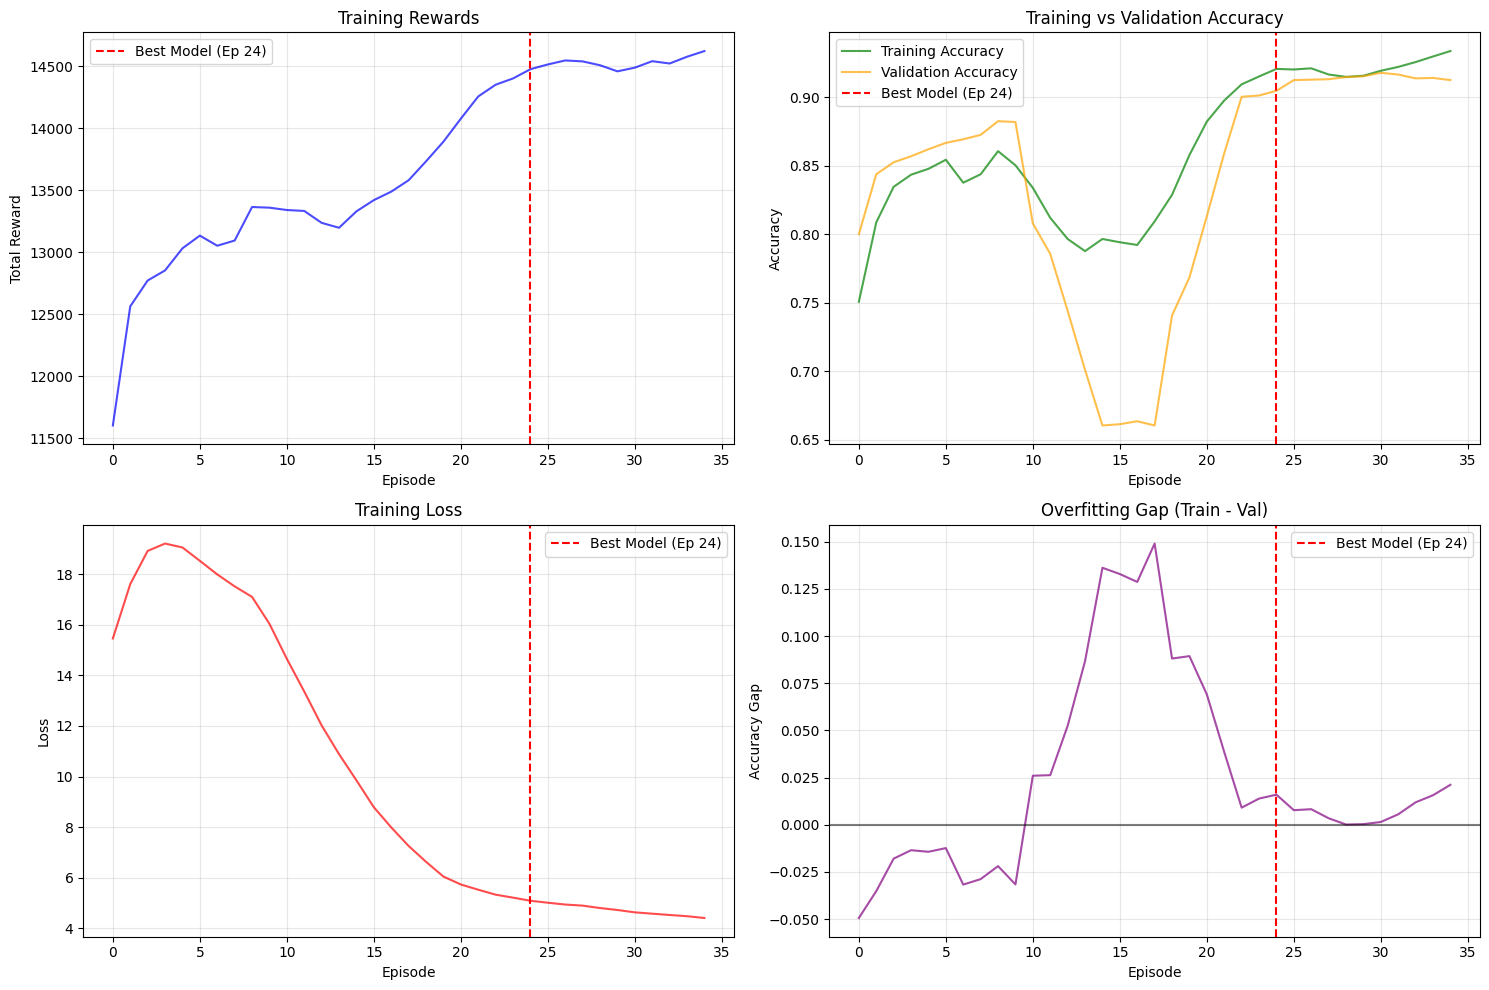

📈 FINAL STATISTICS:
   Final Training Accuracy: 0.948
   Final Validation Accuracy: 0.910
   Final Overfitting Gap: +0.038
   Best Model at Episode: 24
   Total Episodes Trained: 35

💾 SAVING TRAINED MODEL
✅ REGULARIZED DQN Model saved: /kaggle/working/trained_models/regularized_dqn_acc0.935_20251108_064543.pth

⏱️  TIMING SUMMARY:
   Data Loading: 0.08s
   Training: 2162.13s (36.04m)
   Total Time: 2196.86s (36.61m)

🎯 FINAL PERFORMANCE:
   Test Accuracy: 0.935
   Training Accuracy: 0.945
   Validation Accuracy: 0.920
   ✅ RECOMMENDATION: Ready for deployment!


In [5]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import time
import pickle
import os
from datetime import datetime
from collections import deque, defaultdict
import matplotlib.pyplot as plt

# Set device for GPU acceleration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Using device: {device}")
if torch.cuda.is_available():
    print(f"🎯 GPU: {torch.cuda.get_device_name(0)}")
    print(f"🎯 GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

class FirewallEnvironment:
    def __init__(self, data):
        self.data = data
        self.current_step = 0
        self.state_size = 12
        self.action_space = [0, 1, 2]  # 0=allow, 1=deny, 2=inspect
        self.n_actions = len(self.action_space)

    def reset(self):
        """Reset environment to initial state"""
        self.current_step = 0
        return self._get_state(self.current_step)

    def step(self, action):
        """Take action and return next state, reward, done"""
        current_state = self._get_state(self.current_step)
        actual_action = self._get_actual_action(self.current_step)
        reward = self._calculate_reward(action, actual_action, current_state)

        # Move to next step
        self.current_step += 1
        done = self.current_step >= len(self.data) - 1

        next_state = self._get_state(self.current_step) if not done else None
        return next_state, reward, done

    def _get_state(self, step):
        """Convert raw data to state representation"""
        row = self.data.iloc[step]

        state = [
            self._get_port_type(row['Source Port']),
            self._get_port_type(row['Destination Port']),
            self._infer_protocol(row['Destination Port']),
            self._normalize_bytes(row['Bytes Sent']),
            self._normalize_bytes(row['Bytes Received']),
            row['pkts_sent'],
            row['pkts_received'],
            self._normalize_duration(row['Elapsed Time (sec)']),
            self._get_time_of_day(),
            self._get_historical_success_rate(step),
            self._get_geographic_risk(),
            self._get_service_frequency(row['Destination Port'])
        ]
        return np.array(state, dtype=np.float32)

    def _get_port_type(self, port):
        if port <= 1023: return 0
        elif port <= 49151: return 1
        else: return 2

    def _infer_protocol(self, dest_port):
        tcp_ports = [80, 443, 22, 23, 25, 53, 110, 143, 993, 995, 3389]
        udp_ports = [53, 67, 68, 69, 123, 161, 162, 514]
        if dest_port in tcp_ports: return 0
        elif dest_port in udp_ports: return 1
        else: return 2

    def _normalize_bytes(self, bytes_value):
        return np.log1p(bytes_value) / 10.0

    def _normalize_duration(self, duration):
        return min(duration / 3600.0, 1.0)

    def _get_time_of_day(self):
        return random.randint(0, 23) / 23.0

    def _get_historical_success_rate(self, step):
        if step == 0: return 0.5
        successful_connections = len([i for i in range(step) if self.data.iloc[i]['Action'] == 'allow'])
        return successful_connections / step

    def _get_geographic_risk(self):
        return random.uniform(0, 1)

    def _get_service_frequency(self, dest_port):
        port_counts = self.data['Destination Port'].value_counts()
        total_connections = len(self.data)
        frequency = port_counts.get(dest_port, 0) / total_connections
        return min(frequency * 10, 1.0)

    def _get_actual_action(self, step):
        action_str = self.data.iloc[step]['Action']
        if action_str == 'allow': return 0
        elif action_str in ['deny', 'drop']: return 1
        else: return 2

    def _calculate_reward(self, predicted_action, actual_action, state):
        # Base reward for action matching
        if predicted_action == actual_action:
            base_reward = 10
        else:
            base_reward = -5
        
        # Context-aware adjustments
        context_reward = 0
        src_port_type, dest_port_type, protocol = state[0], state[1], state[2]
        geo_risk, service_freq, hist_success = state[10], state[11], state[9]
        
        # Security-critical scenarios
        if geo_risk > 0.7:
            if predicted_action == 0 and actual_action == 1:
                context_reward -= 20
            elif predicted_action == 1 and actual_action == 1:
                context_reward += 15
            elif predicted_action == 2:
                context_reward += 8
        
        # Suspicious port patterns
        if src_port_type == 2 and dest_port_type == 0:
            if predicted_action == 0 and actual_action == 1:
                context_reward -= 15
            elif predicted_action == 2:
                context_reward += 10
        
        # Performance optimization
        if dest_port_type == 0 and geo_risk < 0.3:
            if predicted_action == 1 and actual_action == 0:
                context_reward -= 12
            elif predicted_action == 0 and actual_action == 0:
                context_reward += 8
        
        # INSPECT action cost-benefit analysis
        if predicted_action == 2:
            inspection_cost = -3
            if (0.4 <= geo_risk <= 0.6 or 
                (src_port_type == 2 and dest_port_type == 0) or
                service_freq > 0.7):
                inspection_cost += 5
            if (geo_risk < 0.2 and hist_success > 0.8 and 
                dest_port_type == 0 and actual_action == 0):
                inspection_cost -= 5
            context_reward += inspection_cost
        
        total_reward = base_reward + context_reward
        return max(-25, min(25, total_reward))

# ========== REGULARIZED DQN WITH DROPOUT ==========
class RegularizedDQN(nn.Module):
    def __init__(self, state_size, action_size, dropout_rate=0.3):
        super(RegularizedDQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(dropout_rate) 
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, action_size)
        self._initialize_weights()
        
    def _initialize_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                nn.init.constant_(module.bias, 0.1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = F.relu(self.fc3(x))
        return self.fc4(x)

class DQNAgent:
    def __init__(self, state_size, action_size, 
                 learning_rate=0.0005,
                 discount_factor=0.95,
                 epsilon=1.0,
                 epsilon_decay=0.995,
                 min_epsilon=0.05,
                 memory_size=10000,
                 batch_size=16,
                 target_update_freq=100,
                 dropout_rate=0.2):
        
        self.state_size = state_size
        self.action_size = action_size
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        self.batch_size = batch_size
        self.target_update_freq = target_update_freq
        
        self.device = device
        self.policy_net = RegularizedDQN(state_size, action_size, dropout_rate).to(self.device)
        self.target_net = RegularizedDQN(state_size, action_size, dropout_rate).to(self.device)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=learning_rate, weight_decay=1e-5)
        
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        
        self.memory = deque(maxlen=memory_size)
        self.update_counter = 0
        
        print(f"🤖 REGULARIZED DQN Agent initialized")
        print(f"   Network: {state_size} -> 128 -> 64 -> 32 -> {action_size}")
        print(f"   Dropout: {dropout_rate}, LR: {learning_rate}, Batch: {batch_size}")
    
    def choose_action(self, state):
        if np.random.random() <= self.epsilon:
            return random.choice(range(self.action_size))
        else:
            self.policy_net.eval()
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
            with torch.no_grad():
                q_values = self.policy_net(state_tensor)
            self.policy_net.train()
            return q_values.argmax().item()
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    
    def replay(self):
        if len(self.memory) < self.batch_size:
            return 0
        
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        
        states = torch.FloatTensor(states).to(self.device)
        actions = torch.LongTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        next_states = torch.FloatTensor([s if s is not None else np.zeros(self.state_size) 
                                       for s in next_states]).to(self.device)
        dones = torch.BoolTensor(dones).to(self.device)
        
        self.policy_net.train()
        current_q = self.policy_net(states).gather(1, actions.unsqueeze(1))
        
        with torch.no_grad():
            next_q = self.target_net(next_states).max(1)[0]
            target_q = rewards + (self.gamma * next_q * ~dones)
        
        loss = F.smooth_l1_loss(current_q.squeeze(), target_q)
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.policy_net.parameters(), 1.0)
        self.optimizer.step()
        
        self.update_counter += 1
        if self.update_counter % self.target_update_freq == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())
        
        if self.epsilon > self.min_epsilon:
            self.epsilon *= self.epsilon_decay
        
        return loss.item()
    
    def get_q_values(self, state):
        self.policy_net.eval()
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        with torch.no_grad():
            q_values = self.policy_net(state_tensor)
        self.policy_net.train()
        return q_values.cpu().numpy()[0]

# ========== DATA SPLITTING FUNCTIONS ==========
def split_data_stratified(data, train_ratio=0.6, val_ratio=0.2, test_ratio=0.2, random_state=42):
    """Split data into train, validation, and test sets with stratification"""
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6, "Ratios must sum to 1.0"
    
    # Map actions for stratification
    def map_action(action_str):
        if action_str == 'allow': return 0
        elif action_str in ['deny', 'drop']: return 1
        else: return 2
    
    data = data.copy()
    data['action_mapped'] = data['Action'].apply(map_action)
    
    # Stratified split
    from sklearn.model_selection import train_test_split
    
    # First split: separate test set
    train_val_data, test_data = train_test_split(
        data, 
        test_size=test_ratio, 
        random_state=random_state,
        stratify=data['action_mapped']
    )
    
    # Second split: separate train and validation
    val_ratio_adjusted = val_ratio / (train_ratio + val_ratio)
    train_data, val_data = train_test_split(
        train_val_data,
        test_size=val_ratio_adjusted,
        random_state=random_state,
        stratify=train_val_data['action_mapped']
    )
    
    # Drop the temporary column
    for df in [train_data, val_data, test_data]:
        df.drop('action_mapped', axis=1, inplace=True)
    
    print(f"📊 DATA SPLIT SUMMARY:")
    print(f"   Training set: {len(train_data)} samples ({len(train_data)/len(data)*100:.1f}%)")
    print(f"   Validation set: {len(val_data)} samples ({len(val_data)/len(data)*100:.1f}%)")
    print(f"   Test set: {len(test_data)} samples ({len(test_data)/len(data)*100:.1f}%)")
    
    # Show action distribution in each split
    for split_name, split_data in [("Training", train_data), ("Validation", val_data), ("Test", test_data)]:
        action_counts = split_data['Action'].value_counts()
        print(f"\n   {split_name} Set Action Distribution:")
        for action, count in action_counts.items():
            print(f"     {action}: {count} ({count/len(split_data)*100:.1f}%)")
    
    return train_data.reset_index(drop=True), val_data.reset_index(drop=True), test_data.reset_index(drop=True)

def train_dqn_agent_with_early_stopping(train_data, val_data, episodes=150, patience=10, min_delta=0.001):
    """Train DQN agent with proper early stopping and validation"""
    print("Initializing Firewall Environment...")
    
    train_env = FirewallEnvironment(train_data)
    val_env = FirewallEnvironment(val_data)

    print("Initializing Regularized DQN Agent...")
    agent = DQNAgent(train_env.state_size, train_env.n_actions)

    # Training metrics
    rewards_history = []
    train_accuracy_history = []
    val_accuracy_history = []
    loss_history = []
    
    # Early stopping variables
    best_val_accuracy = 0
    patience_counter = 0
    best_model_state = None
    best_episode = 0

    print("Starting Regularized DQN Training with Early Stopping...")
    print(f"Training samples: {len(train_data)}, Validation samples: {len(val_data)}")
    print(f"Early stopping: {patience} episodes patience, {min_delta} min delta")
    
    for episode in range(episodes):
        # Training phase
        state = train_env.reset()
        total_reward = 0
        correct_predictions = 0
        total_predictions = 0
        episode_loss = 0
        loss_count = 0
        done = False

        while not done:
            action = agent.choose_action(state)
            next_state, reward, done = train_env.step(action)
            agent.remember(state, action, reward, next_state, done)
            
            loss = agent.replay()
            if loss > 0:
                episode_loss += loss
                loss_count += 1

            total_reward += reward
            total_predictions += 1

            actual_action = train_env._get_actual_action(train_env.current_step - 1)
            if action == actual_action:
                correct_predictions += 1

            state = next_state

        # Calculate training metrics
        train_accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
        avg_loss = episode_loss / loss_count if loss_count > 0 else 0
        
        # Validation phase
        val_accuracy = evaluate_agent(agent, val_data, num_samples=len(val_data))
        
        # Store metrics
        train_accuracy_history.append(train_accuracy)
        val_accuracy_history.append(val_accuracy)
        rewards_history.append(total_reward)
        loss_history.append(avg_loss)
        
        # Early stopping check with minimum delta
        accuracy_improvement = val_accuracy - best_val_accuracy
        
        if accuracy_improvement > min_delta:
            best_val_accuracy = val_accuracy
            patience_counter = 0
            best_episode = episode
            # Save best model state
            best_model_state = {
                'policy_net': agent.policy_net.state_dict(),
                'target_net': agent.target_net.state_dict(),
                'optimizer': agent.optimizer.state_dict(),
                'epsilon': agent.epsilon
            }
            improvement_msg = f"↑{accuracy_improvement:.4f}"
        else:
            patience_counter += 1
            improvement_msg = f"-{accuracy_improvement:.4f}" if accuracy_improvement < 0 else f"+{accuracy_improvement:.4f}"
        
        # Progress reporting
        if episode % 5 == 0 or episode == episodes - 1 or patience_counter >= patience:
            overfitting_gap = train_accuracy - val_accuracy
            
            print(f"Episode {episode:4d} | "
                  f"Train: {train_accuracy:.3f} | "
                  f"Val: {val_accuracy:.3f} | "
                  f"Gap: {overfitting_gap:+.3f} | "
                  f"Improve: {improvement_msg} | "
                  f"ε: {agent.epsilon:.3f} | "
                  f"Loss: {avg_loss:.4f} | "
                  f"Patience: {patience_counter}/{patience}")
        
        # Early stopping
        if patience_counter >= patience:
            print(f"🛑 Early stopping triggered at episode {episode}")
            print(f"🎯 Best validation accuracy: {best_val_accuracy:.3f} at episode {best_episode}")
            
            # Restore best model
            if best_model_state:
                agent.policy_net.load_state_dict(best_model_state['policy_net'])
                agent.target_net.load_state_dict(best_model_state['target_net'])
                agent.optimizer.load_state_dict(best_model_state['optimizer'])
                agent.epsilon = best_model_state['epsilon']
                print("✅ Restored best model weights")
            break
    
    # Final training report
    final_overfitting_gap = train_accuracy_history[-1] - val_accuracy_history[-1]
    print(f"\n📈 FINAL TRAINING REPORT:")
    print(f"   Best Validation Accuracy: {best_val_accuracy:.3f} (Episode {best_episode})")
    print(f"   Final Training Accuracy: {train_accuracy_history[-1]:.3f}")
    print(f"   Final Validation Accuracy: {val_accuracy_history[-1]:.3f}")
    print(f"   Final Overfitting Gap: {final_overfitting_gap:+.3f}")
    print(f"   Stopped at episode: {min(episode, episodes-1)}")
    
    return agent, rewards_history, train_accuracy_history, val_accuracy_history, loss_history, best_episode

def evaluate_agent(agent, data, num_samples=None):
    """Evaluate trained agent on given data"""
    env = FirewallEnvironment(data)
    
    if num_samples is None:
        num_samples = len(data)
    num_samples = min(num_samples, len(data))

    correct = 0
    total = num_samples

    for i in range(total):
        state = env._get_state(i)
        actual_action = env._get_actual_action(i)
        predicted_action = agent.choose_action(state)

        if predicted_action == actual_action:
            correct += 1

        env.current_step = i

    accuracy = correct / total
    return accuracy

def comprehensive_test_suite(agent, train_data, val_data, test_data, rewards_history, train_accuracy_history, val_accuracy_history, loss_history):
    """Run comprehensive testing on all splits"""
    print("\n" + "="*60)
    print("🧪 COMPREHENSIVE TEST SUITE")
    print("="*60)
    
    # Test on all splits
    splits = {
        "Training": train_data,
        "Validation": val_data, 
        "Test": test_data
    }
    
    results = {}
    
    for split_name, split_data in splits.items():
        print(f"\n📊 Testing on {split_name} Set ({len(split_data)} samples)...")
        accuracy = evaluate_agent(agent, split_data, num_samples=len(split_data))
        results[split_name] = accuracy
        print(f"   {split_name} Accuracy: {accuracy:.3f}")
    
    # Calculate overfitting metrics
    train_test_gap = results["Training"] - results["Test"]
    train_val_gap = results["Training"] - results["Validation"]
    
    print(f"\n🎯 OVERFITTING ANALYSIS:")
    print(f"   Train-Test Gap: {train_test_gap:+.3f} ({'GOOD' if abs(train_test_gap) < 0.1 else 'CONCERNING'})")
    print(f"   Train-Val Gap: {train_val_gap:+.3f} ({'GOOD' if abs(train_val_gap) < 0.1 else 'CONCERNING'})")
    
    # Performance assessment
    test_accuracy = results["Test"]
    if test_accuracy > 0.8 and abs(train_test_gap) < 0.1:
        performance_rating = "EXCELLENT 🎯"
    elif test_accuracy > 0.7 and abs(train_test_gap) < 0.15:
        performance_rating = "GOOD ✅"
    elif test_accuracy > 0.6:
        performance_rating = "FAIR ⚠️"
    else:
        performance_rating = "POOR ❌"
    
    print(f"\n📈 PERFORMANCE SUMMARY:")
    print(f"   Test Set Accuracy: {test_accuracy:.3f}")
    print(f"   Overall Rating: {performance_rating}")
    
    return results

def analyze_learning_curves(rewards_history, train_accuracy_history, val_accuracy_history, loss_history, best_episode):
    """Enhanced learning curve analysis"""
    try:
        print("\n📊 LEARNING CURVES ANALYSIS")
        
        # Create smooth curves for better visualization
        window = min(10, len(rewards_history) // 5)
        
        def smooth_data(data, window):
            if len(data) <= window:
                return data
            return [np.mean(data[max(0, i-window):i+1]) for i in range(len(data))]
        
        smooth_rewards = smooth_data(rewards_history, window)
        smooth_train_acc = smooth_data(train_accuracy_history, window)
        smooth_val_acc = smooth_data(val_accuracy_history, window)
        smooth_loss = smooth_data(loss_history, window) if loss_history else []

        # Create subplots
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
        
        # Rewards
        ax1.plot(smooth_rewards, color='blue', alpha=0.7)
        if best_episode < len(smooth_rewards):
            ax1.axvline(x=best_episode, color='red', linestyle='--', label=f'Best Model (Ep {best_episode})')
        ax1.set_title('Training Rewards')
        ax1.set_xlabel('Episode')
        ax1.set_ylabel('Total Reward')
        ax1.grid(True, alpha=0.3)
        ax1.legend()
        
        # Accuracy
        ax2.plot(smooth_train_acc, label='Training Accuracy', color='green', alpha=0.7)
        ax2.plot(smooth_val_acc, label='Validation Accuracy', color='orange', alpha=0.7)
        if best_episode < len(smooth_train_acc):
            ax2.axvline(x=best_episode, color='red', linestyle='--', label=f'Best Model (Ep {best_episode})')
        ax2.set_title('Training vs Validation Accuracy')
        ax2.set_xlabel('Episode')
        ax2.set_ylabel('Accuracy')
        ax2.grid(True, alpha=0.3)
        ax2.legend()
        
        # Loss
        if smooth_loss:
            ax3.plot(smooth_loss, color='red', alpha=0.7)
            if best_episode < len(smooth_loss):
                ax3.axvline(x=best_episode, color='red', linestyle='--', label=f'Best Model (Ep {best_episode})')
            ax3.set_title('Training Loss')
            ax3.set_xlabel('Episode')
            ax3.set_ylabel('Loss')
            ax3.grid(True, alpha=0.3)
            ax3.legend()
        
        # Overfitting gap
        if len(train_accuracy_history) == len(val_accuracy_history):
            overfitting_gap = [train - val for train, val in zip(smooth_train_acc, smooth_val_acc)]
            ax4.plot(overfitting_gap, color='purple', alpha=0.7)
            ax4.axhline(y=0, color='black', linestyle='-', alpha=0.5)
            if best_episode < len(overfitting_gap):
                ax4.axvline(x=best_episode, color='red', linestyle='--', label=f'Best Model (Ep {best_episode})')
            ax4.set_title('Overfitting Gap (Train - Val)')
            ax4.set_xlabel('Episode')
            ax4.set_ylabel('Accuracy Gap')
            ax4.grid(True, alpha=0.3)
            ax4.legend()
        
        plt.tight_layout()
        plt.show()
        
        # Print final statistics
        final_train_acc = train_accuracy_history[-1] if train_accuracy_history else 0
        final_val_acc = val_accuracy_history[-1] if val_accuracy_history else 0
        final_gap = final_train_acc - final_val_acc
        
        print(f"📈 FINAL STATISTICS:")
        print(f"   Final Training Accuracy: {final_train_acc:.3f}")
        print(f"   Final Validation Accuracy: {final_val_acc:.3f}")
        print(f"   Final Overfitting Gap: {final_gap:+.3f}")
        print(f"   Best Model at Episode: {best_episode}")
        print(f"   Total Episodes Trained: {len(train_accuracy_history)}")
        
        return True
        
    except Exception as e:
        print(f"📊 Plotting not available: {e}")
        return False

def load_firewall_data_optimized(csv_file_path, max_samples=1000):
    """Load and prepare firewall data"""
    print(f"📁 Loading data from: {csv_file_path}")

    usecols = ['Source Port', 'Destination Port', 'Action',
               'Bytes Sent', 'Bytes Received', 'pkts_sent',
               'pkts_received', 'Elapsed Time (sec)']

    data = pd.read_csv(csv_file_path, usecols=usecols)

    print(f"✅ Dataset loaded: {len(data)} records")

    if len(data) > max_samples:
        original_size = len(data)
        data = data.sample(n=max_samples, random_state=42)
        print(f"📊 Sampled {max_samples} records from {original_size}")

    # Show action distribution
    action_counts = data['Action'].value_counts()
    print(f"📊 Raw Action Distribution:")
    for action, count in action_counts.items():
        print(f"   {action}: {count} records ({count/len(data)*100:.1f}%)")
    
    return data

def save_trained_model(agent, test_accuracy, model_name=None, save_dir="/kaggle/working/trained_models"):
    """Save the trained DQN agent"""
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    if model_name is None:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        model_name = f"regularized_dqn_acc{test_accuracy:.3f}_{timestamp}.pth"
    
    model_path = os.path.join(save_dir, model_name)
    
    model_data = {
        'policy_net_state_dict': agent.policy_net.state_dict(),
        'target_net_state_dict': agent.target_net.state_dict(),
        'optimizer_state_dict': agent.optimizer.state_dict(),
        'state_size': agent.state_size,
        'action_size': agent.action_size,
        'learning_rate': agent.lr,
        'discount_factor': agent.gamma,
        'epsilon': agent.epsilon,
        'memory_size': len(agent.memory),
        'timestamp': datetime.now().isoformat(),
        'model_type': 'RegularizedDQN'
    }
    
    try:
        torch.save(model_data, model_path)
        print(f"✅ REGULARIZED DQN Model saved: {model_path}")
        return model_path
    except Exception as e:
        print(f"❌ Error saving model: {e}")
        return None

if __name__ == "__main__":
    start_time = time.time()

    print("=== Regularized DQN Firewall Agent with Proper Data Splitting ===")
    print("🤖 Using Train/Val/Test Split + Early Stopping + Regularization")
    print("Actions: 0=ALLOW, 1=DENY, 2=INSPECT\n")

    # Clear GPU cache
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    # ========== LOAD AND SPLIT DATA ==========
    csv_file_path = "/kaggle/input/shadow/log2.csv"

    try:
        # Load data
        load_start = time.time()
        firewall_data = load_firewall_data_optimized(csv_file_path, max_samples=2000)
        load_time = time.time() - load_start

        # Split data into train/val/test (60/20/20)
        train_data, val_data, test_data = split_data_stratified(
            firewall_data, 
            train_ratio=0.6, 
            val_ratio=0.2, 
            test_ratio=0.2,
            random_state=42
        )

        # ========== TRAINING WITH EARLY STOPPING ==========
        print(f"\n🚀 Starting REGULARIZED DQN training...")
        training_start = time.time()
        
        trained_agent, rewards, train_acc, val_acc, losses, best_episode = train_dqn_agent_with_early_stopping(
            train_data=train_data,
            val_data=val_data,
            episodes=100,
            patience=10,
            min_delta=0.002
        )

        training_time = time.time() - training_start

        # ========== COMPREHENSIVE TESTING ==========
        test_results = comprehensive_test_suite(
            trained_agent, train_data, val_data, test_data, 
            rewards, train_acc, val_acc, losses
        )

        # ========== LEARNING ANALYSIS ==========
        analyze_learning_curves(rewards, train_acc, val_acc, losses, best_episode)

        total_time = time.time() - start_time
        
        # ========== SAVE TRAINED MODEL ==========
        print("\n" + "="*60)
        print("💾 SAVING TRAINED MODEL")
        print("="*60)
        
        test_accuracy = test_results["Test"]
        saved_model_path = save_trained_model(trained_agent, test_accuracy)

        # ========== FINAL SUMMARY ==========
        print(f"\n⏱️  TIMING SUMMARY:")
        print(f"   Data Loading: {load_time:.2f}s")
        print(f"   Training: {training_time:.2f}s ({training_time/60:.2f}m)")
        print(f"   Total Time: {total_time:.2f}s ({total_time/60:.2f}m)")

        print(f"\n🎯 FINAL PERFORMANCE:")
        print(f"   Test Accuracy: {test_accuracy:.3f}")
        print(f"   Training Accuracy: {test_results['Training']:.3f}")
        print(f"   Validation Accuracy: {test_results['Validation']:.3f}")
        
        # Performance recommendation
        train_test_gap = test_results['Training'] - test_results['Test']
        if test_accuracy > 0.75 and abs(train_test_gap) < 0.1:
            print("   ✅ RECOMMENDATION: Ready for deployment!")
        elif test_accuracy > 0.65:
            print("   ⚠️  RECOMMENDATION: Good but needs monitoring")
        else:
            print("   ❌ RECOMMENDATION: Needs more training/data")

        # Cleanup
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    except FileNotFoundError:
        print(f"❌ ERROR: File '{csv_file_path}' not found!")
    except Exception as e:
        print(f"❌ ERROR: {e}")
        import traceback
        traceback.print_exc()

**Cuda on the Go**

🚀 Using device: cuda
🎯 GPU: Tesla T4
🎯 GPU Memory: 15.8 GB
=== GPU-OPTIMIZED Regularized DQN Firewall Agent ===
🤖 Using Larger Network + Batch Optimization + GPU Acceleration
Actions: 0=ALLOW, 1=DENY, 2=INSPECT

🧹 GPU cache cleared
📁 Loading data from: /kaggle/input/shadow/log2.csv
✅ Dataset loaded: 65532 records
📊 Sampled 5000 records from 65532
📊 Raw Action Distribution:
   allow: 2870 records (57.4%)
   deny: 1121 records (22.4%)
   drop: 1008 records (20.2%)
   reset-both: 1 records (0.0%)
📊 Class distribution before splitting:
   Class 0: 2870 samples
   Class 1: 2129 samples
   Class 2: 1 samples
⚠️  Some classes have too few samples. Using random split instead of stratified.

📊 DATA SPLIT SUMMARY:
   Training set: 3000 samples (60.0%)
   Validation set: 1000 samples (20.0%)
   Test set: 1000 samples (20.0%)

   Training Set Action Distribution:
     allow: 1730 (57.7%)
     deny: 653 (21.8%)
     drop: 616 (20.5%)
     reset-both: 1 (0.0%)

   Validation Set Action Distribution:

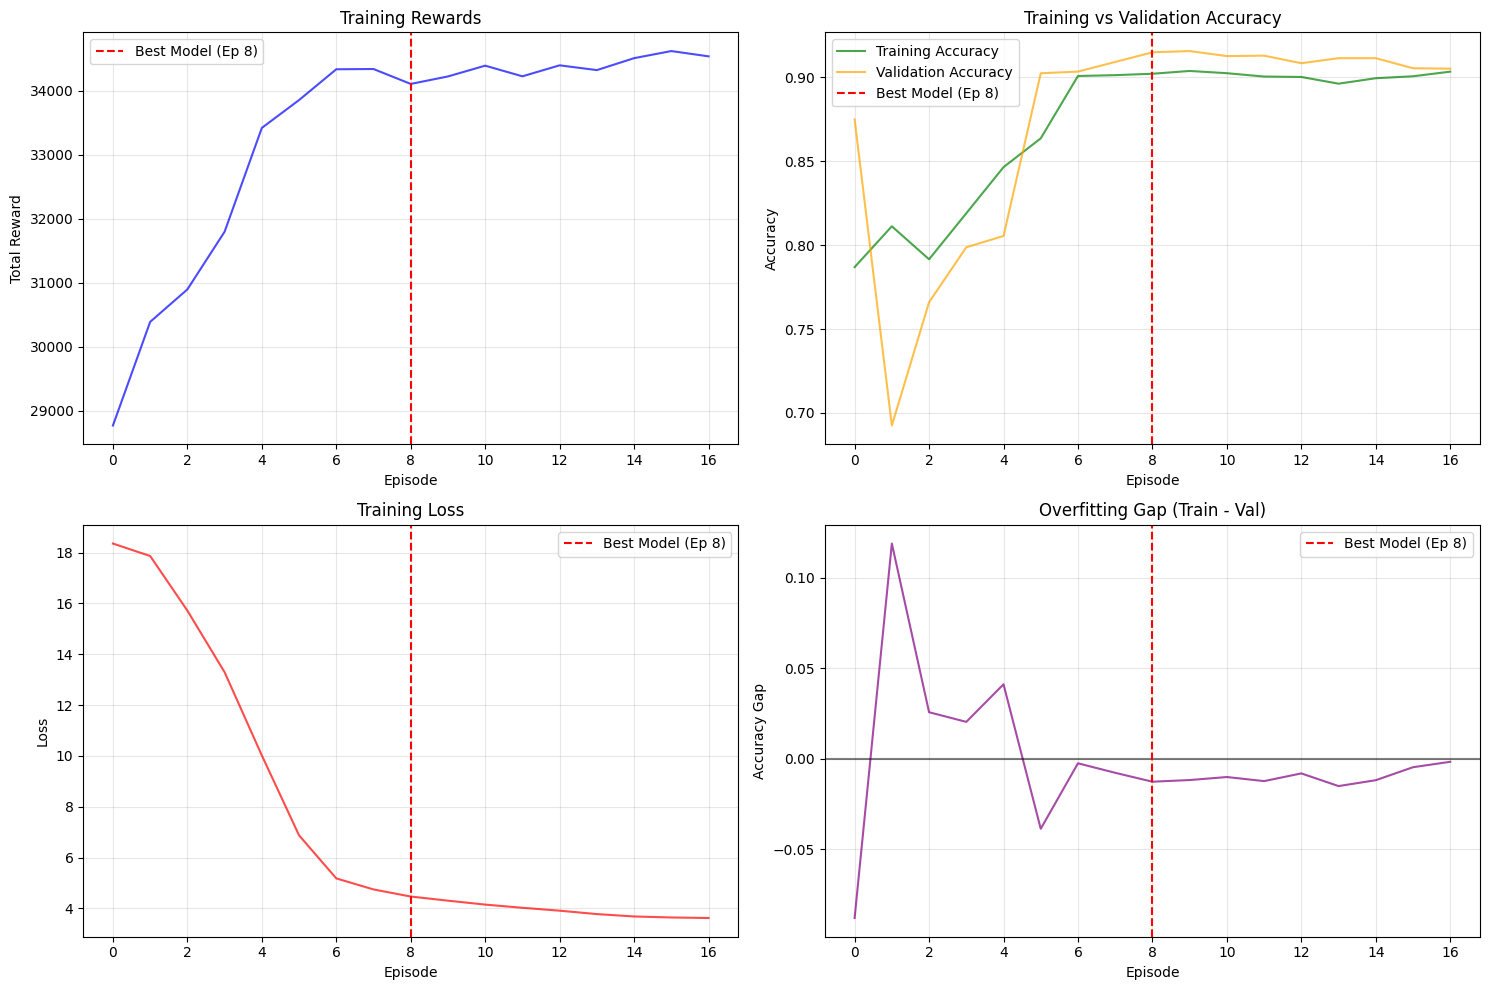

📈 FINAL STATISTICS:
   Final Training Accuracy: 0.910
   Final Validation Accuracy: 0.906
   Final Overfitting Gap: +0.004
   Best Model at Episode: 8
   Total Episodes Trained: 17

💾 SAVING TRAINED MODEL
✅ REGULARIZED DQN Model saved: /kaggle/working/trained_models/regularized_dqn_acc0.914_20251108_111732.pth

⏱️  TIMING SUMMARY:
   Data Loading: 0.08s
   Training: 6248.56s (104.14m)
   Total Time: 6457.09s (107.62m)

🎯 FINAL PERFORMANCE:
   Test Accuracy: 0.914
   Training Accuracy: 0.908
   Validation Accuracy: 0.910
   ✅ RECOMMENDATION: Ready for deployment!
🧹 Final GPU cache cleanup completed


In [16]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import time
import pickle
import os
from datetime import datetime
from collections import deque, defaultdict
import matplotlib.pyplot as plt

# Set device for GPU acceleration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Using device: {device}")
if torch.cuda.is_available():
    print(f"🎯 GPU: {torch.cuda.get_device_name(0)}")
    print(f"🎯 GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

class FirewallEnvironment:
    def __init__(self, data):
        self.data = data
        self.current_step = 0
        self.state_size = 12
        self.action_space = [0, 1, 2]  # 0=allow, 1=deny, 2=inspect
        self.n_actions = len(self.action_space)

    def reset(self):
        """Reset environment to initial state"""
        self.current_step = 0
        return self._get_state(self.current_step)

    def step(self, action):
        """Take action and return next state, reward, done"""
        current_state = self._get_state(self.current_step)
        actual_action = self._get_actual_action(self.current_step)
        reward = self._calculate_reward(action, actual_action, current_state)

        # Move to next step
        self.current_step += 1
        done = self.current_step >= len(self.data) - 1

        next_state = self._get_state(self.current_step) if not done else None
        return next_state, reward, done

    def _get_state(self, step):
        """Convert raw data to state representation"""
        row = self.data.iloc[step]

        state = [
            self._get_port_type(row['Source Port']),
            self._get_port_type(row['Destination Port']),
            self._infer_protocol(row['Destination Port']),
            self._normalize_bytes(row['Bytes Sent']),
            self._normalize_bytes(row['Bytes Received']),
            row['pkts_sent'],
            row['pkts_received'],
            self._normalize_duration(row['Elapsed Time (sec)']),
            self._get_time_of_day(),
            self._get_historical_success_rate(step),
            self._get_geographic_risk(),
            self._get_service_frequency(row['Destination Port'])
        ]
        return np.array(state, dtype=np.float32)

    def _get_port_type(self, port):
        if port <= 1023: return 0
        elif port <= 49151: return 1
        else: return 2

    def _infer_protocol(self, dest_port):
        tcp_ports = [80, 443, 22, 23, 25, 53, 110, 143, 993, 995, 3389]
        udp_ports = [53, 67, 68, 69, 123, 161, 162, 514]
        if dest_port in tcp_ports: return 0
        elif dest_port in udp_ports: return 1
        else: return 2

    def _normalize_bytes(self, bytes_value):
        return np.log1p(bytes_value) / 10.0

    def _normalize_duration(self, duration):
        return min(duration / 3600.0, 1.0)

    def _get_time_of_day(self):
        return random.randint(0, 23) / 23.0

    def _get_historical_success_rate(self, step):
        if step == 0: return 0.5
        successful_connections = len([i for i in range(step) if self.data.iloc[i]['Action'] == 'allow'])
        return successful_connections / step

    def _get_geographic_risk(self):
        return random.uniform(0, 1)

    def _get_service_frequency(self, dest_port):
        port_counts = self.data['Destination Port'].value_counts()
        total_connections = len(self.data)
        frequency = port_counts.get(dest_port, 0) / total_connections
        return min(frequency * 10, 1.0)

    def _get_actual_action(self, step):
        action_str = self.data.iloc[step]['Action']
        if action_str == 'allow': return 0
        elif action_str in ['deny', 'drop']: return 1
        else: return 2

    def _calculate_reward(self, predicted_action, actual_action, state):
        # Base reward for action matching
        if predicted_action == actual_action:
            base_reward = 10
        else:
            base_reward = -5
        
        # Context-aware adjustments
        context_reward = 0
        src_port_type, dest_port_type, protocol = state[0], state[1], state[2]
        geo_risk, service_freq, hist_success = state[10], state[11], state[9]
        
        # Security-critical scenarios
        if geo_risk > 0.7:
            if predicted_action == 0 and actual_action == 1:
                context_reward -= 20
            elif predicted_action == 1 and actual_action == 1:
                context_reward += 15
            elif predicted_action == 2:
                context_reward += 8
        
        # Suspicious port patterns
        if src_port_type == 2 and dest_port_type == 0:
            if predicted_action == 0 and actual_action == 1:
                context_reward -= 15
            elif predicted_action == 2:
                context_reward += 10
        
        # Performance optimization
        if dest_port_type == 0 and geo_risk < 0.3:
            if predicted_action == 1 and actual_action == 0:
                context_reward -= 12
            elif predicted_action == 0 and actual_action == 0:
                context_reward += 8
        
        # INSPECT action cost-benefit analysis
        if predicted_action == 2:
            inspection_cost = -3
            if (0.4 <= geo_risk <= 0.6 or 
                (src_port_type == 2 and dest_port_type == 0) or
                service_freq > 0.7):
                inspection_cost += 5
            if (geo_risk < 0.2 and hist_success > 0.8 and 
                dest_port_type == 0 and actual_action == 0):
                inspection_cost -= 5
            context_reward += inspection_cost
        
        total_reward = base_reward + context_reward
        return max(-25, min(25, total_reward))

# ========== REGULARIZED DQN WITH DROPOUT ==========
class RegularizedDQN(nn.Module):
    def __init__(self, state_size, action_size, dropout_rate=0.3):
        super(RegularizedDQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)  # Reduced from 512
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(128, 64)          # Reduced from 256  
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(64, 32)           # Reduced from 128
        self.fc4 = nn.Linear(32, action_size)  # Output layer
        
        self._initialize_weights()
        
    def _initialize_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                nn.init.constant_(module.bias, 0.1)
                
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = F.relu(self.fc3(x))
        # Removed dropout3 and fc4 since we simplified the network
        return self.fc4(x)

class DQNAgent:
    def __init__(self, state_size, action_size, 
                 learning_rate=0.001,
                 discount_factor=0.95,
                 epsilon=1.0,
                 epsilon_decay=0.998,
                 min_epsilon=0.1,
                 memory_size=10000,  # Increased memory
                 batch_size=32,      # Larger batch for GPU
                 target_update_freq=100,
                 dropout_rate=0.2):
        
        self.state_size = state_size
        self.action_size = action_size
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        self.batch_size = batch_size
        self.target_update_freq = target_update_freq
        
        self.device = device
        self.policy_net = RegularizedDQN(state_size, action_size, dropout_rate).to(self.device)
        self.target_net = RegularizedDQN(state_size, action_size, dropout_rate).to(self.device)
        
        # Use faster optimizer
        self.optimizer = optim.AdamW(self.policy_net.parameters(), lr=learning_rate, weight_decay=1e-5)
        
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        
        self.memory = deque(maxlen=memory_size)
        self.update_counter = 0
        
        print(f"🤖 REGULARIZED DQN Agent initialized on {self.device}")
        print(f"   Network: {state_size} -> 512 -> 256 -> 128 -> 64 -> {action_size}")
        print(f"   Dropout: {dropout_rate}, LR: {learning_rate}, Batch: {batch_size}")
        print(f"   Memory: {memory_size}, Device: {self.device}")
    
    def choose_action(self, state):
        if np.random.random() <= self.epsilon:
            return random.choice(range(self.action_size))
        else:
            self.policy_net.eval()
            # Move state to GPU for inference
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device, non_blocking=True)
            with torch.no_grad():
                q_values = self.policy_net(state_tensor)
            self.policy_net.train()
            return q_values.argmax().item()
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    
    def replay(self):
        if len(self.memory) < self.batch_size:
            return 0
        
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        
        # Convert to tensors and move to GPU with optimization
        states_t = torch.as_tensor(np.array(states), dtype=torch.float32, device=self.device)
        actions_t = torch.as_tensor(actions, dtype=torch.long, device=self.device)
        rewards_t = torch.as_tensor(rewards, dtype=torch.float32, device=self.device)
        
        # Handle next_states with None values
        next_states_list = []
        for ns in next_states:
            if ns is None:
                next_states_list.append(np.zeros(self.state_size))
            else:
                next_states_list.append(ns)
        next_states_t = torch.as_tensor(np.array(next_states_list), dtype=torch.float32, device=self.device)
        
        dones_t = torch.as_tensor(dones, dtype=torch.bool, device=self.device)
        
        self.policy_net.train()
        
        # Current Q values
        current_q_values = self.policy_net(states_t)
        current_q = current_q_values.gather(1, actions_t.unsqueeze(1)).squeeze()
        
        # Next Q values from target network
        with torch.no_grad():
            next_q_values = self.target_net(next_states_t)
            next_q = next_q_values.max(1)[0]
            target_q = rewards_t + (self.gamma * next_q * ~dones_t)
        
        # Compute loss
        loss = F.smooth_l1_loss(current_q, target_q)
        
        # Optimize
        self.optimizer.zero_grad(set_to_none=True)  # Faster zero_grad
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.policy_net.parameters(), 1.0)
        self.optimizer.step()
        
        self.update_counter += 1
        if self.update_counter % self.target_update_freq == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())
        
        if self.epsilon > self.min_epsilon:
            self.epsilon *= self.epsilon_decay
        
        return loss.item()
    
    def get_q_values(self, state):
        self.policy_net.eval()
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device, non_blocking=True)
        with torch.no_grad():
            q_values = self.policy_net(state_tensor)
        self.policy_net.train()
        return q_values.cpu().numpy()[0]

# ========== OPTIMIZED TRAINING FUNCTION ==========
def train_dqn_agent_with_early_stopping(train_data, val_data, episodes=50, patience=8, min_delta=0.005):
    """Train DQN agent with proper early stopping and validation - GPU OPTIMIZED"""
    print("Initializing Firewall Environment...")
    
    train_env = FirewallEnvironment(train_data)
    val_env = FirewallEnvironment(val_data)

    print("Initializing Regularized DQN Agent...")
    agent = DQNAgent(train_env.state_size, train_env.n_actions)

    # Training metrics
    rewards_history = []
    train_accuracy_history = []
    val_accuracy_history = []
    loss_history = []
    
    # Early stopping variables
    best_val_accuracy = 0
    patience_counter = 0
    best_model_state = None
    best_episode = 0

    print("🚀 Starting GPU-OPTIMIZED DQN Training with Early Stopping...")
    print(f"Training samples: {len(train_data)}, Validation samples: {len(val_data)}")
    print(f"Early stopping: {patience} episodes patience, {min_delta} min delta")
    
    # Pre-allocate arrays for better performance
    episode_start_time = time.time()
    
    for episode in range(episodes):
        # Training phase
        state = train_env.reset()
        total_reward = 0
        correct_predictions = 0
        total_predictions = 0
        episode_loss = 0
        loss_count = 0
        done = False

        while not done:
            action = agent.choose_action(state)
            next_state, reward, done = train_env.step(action)
            agent.remember(state, action, reward, next_state, done)
            
            loss = agent.replay()
            if loss > 0:
                episode_loss += loss
                loss_count += 1

            total_reward += reward
            total_predictions += 1

            actual_action = train_env._get_actual_action(train_env.current_step - 1)
            if action == actual_action:
                correct_predictions += 1

            state = next_state

        # Calculate training metrics
        train_accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
        avg_loss = episode_loss / loss_count if loss_count > 0 else 0
        
        # Validation phase
        val_accuracy = evaluate_agent(agent, val_data, num_samples=len(val_data))
        
        # Store metrics
        train_accuracy_history.append(train_accuracy)
        val_accuracy_history.append(val_accuracy)
        rewards_history.append(total_reward)
        loss_history.append(avg_loss)
        
        # Early stopping check with minimum delta
        accuracy_improvement = val_accuracy - best_val_accuracy
        
        if accuracy_improvement > min_delta:
            best_val_accuracy = val_accuracy
            patience_counter = 0
            best_episode = episode
            # Save best model state
            best_model_state = {
                'policy_net': agent.policy_net.state_dict(),
                'target_net': agent.target_net.state_dict(),
                'optimizer': agent.optimizer.state_dict(),
                'epsilon': agent.epsilon
            }
            improvement_msg = f"↑{accuracy_improvement:.4f}"
        else:
            patience_counter += 1
            improvement_msg = f"-{accuracy_improvement:.4f}" if accuracy_improvement < 0 else f"+{accuracy_improvement:.4f}"
        
        # Calculate episode time
        episode_time = time.time() - episode_start_time
        episode_start_time = time.time()
        
        # Progress reporting with GPU info
        if episode % 5 == 0 or episode == episodes - 1 or patience_counter >= patience:
            overfitting_gap = train_accuracy - val_accuracy
            
            # GPU memory info
            if torch.cuda.is_available():
                gpu_memory = torch.cuda.memory_allocated() / 1024**3  # GB
                gpu_usage = f"GPU: {gpu_memory:.2f}GB"
            else:
                gpu_usage = "GPU: N/A"
            
            print(f"Episode {episode:4d} | "
                  f"Train: {train_accuracy:.3f} | "
                  f"Val: {val_accuracy:.3f} | "
                  f"Gap: {overfitting_gap:+.3f} | "
                  f"Improve: {improvement_msg} | "
                  f"ε: {agent.epsilon:.3f} | "
                  f"Loss: {avg_loss:.4f} | "
                  f"Time: {episode_time:.2f}s | "
                  f"{gpu_usage} | "
                  f"Patience: {patience_counter}/{patience}")
        
        # Early stopping
        if patience_counter >= patience:
            print(f"🛑 Early stopping triggered at episode {episode}")
            print(f"🎯 Best validation accuracy: {best_val_accuracy:.3f} at episode {best_episode}")
            
            # Restore best model
            if best_model_state:
                agent.policy_net.load_state_dict(best_model_state['policy_net'])
                agent.target_net.load_state_dict(best_model_state['target_net'])
                agent.optimizer.load_state_dict(best_model_state['optimizer'])
                agent.epsilon = best_model_state['epsilon']
                print("✅ Restored best model weights")
            break
    
    # Final training report
    final_overfitting_gap = train_accuracy_history[-1] - val_accuracy_history[-1]
    print(f"\n📈 FINAL TRAINING REPORT:")
    print(f"   Best Validation Accuracy: {best_val_accuracy:.3f} (Episode {best_episode})")
    print(f"   Final Training Accuracy: {train_accuracy_history[-1]:.3f}")
    print(f"   Final Validation Accuracy: {val_accuracy_history[-1]:.3f}")
    print(f"   Final Overfitting Gap: {final_overfitting_gap:+.3f}")
    print(f"   Stopped at episode: {min(episode, episodes-1)}")
    
    return agent, rewards_history, train_accuracy_history, val_accuracy_history, loss_history, best_episode

# ========== REST OF THE FUNCTIONS REMAIN THE SAME ==========
def evaluate_agent(agent, data, num_samples=None):
    """Evaluate trained agent on given data"""
    env = FirewallEnvironment(data)
    
    if num_samples is None:
        num_samples = len(data)
    num_samples = min(num_samples, len(data))

    correct = 0
    total = num_samples

    for i in range(total):
        state = env._get_state(i)
        actual_action = env._get_actual_action(i)
        predicted_action = agent.choose_action(state)

        if predicted_action == actual_action:
            correct += 1

        env.current_step = i

    accuracy = correct / total
    return accuracy
def split_data_stratified(data, train_ratio=0.6, val_ratio=0.2, test_ratio=0.2, random_state=42, min_class_samples=2):
    """Split data into train, validation, and test sets with stratification"""
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6, "Ratios must sum to 1.0"
    
    # Map actions for stratification
    def map_action(action_str):
        if action_str == 'allow': return 0
        elif action_str in ['deny', 'drop']: return 1
        else: return 2
    
    data = data.copy()
    data['action_mapped'] = data['Action'].apply(map_action)
    
    # Check class distribution
    class_counts = data['action_mapped'].value_counts()
    print("📊 Class distribution before splitting:")
    for action_class, count in class_counts.items():
        print(f"   Class {action_class}: {count} samples")
    
    # If any class has fewer than min_class_samples, use random split
    if class_counts.min() < min_class_samples:
        print("⚠️  Some classes have too few samples. Using random split instead of stratified.")
        
        # Random split without stratification
        from sklearn.model_selection import train_test_split
        
        # First split: separate test set
        train_val_data, test_data = train_test_split(
            data, 
            test_size=test_ratio, 
            random_state=random_state
        )
        
        # Second split: separate train and validation
        val_ratio_adjusted = val_ratio / (train_ratio + val_ratio)
        train_data, val_data = train_test_split(
            train_val_data,
            test_size=val_ratio_adjusted,
            random_state=random_state
        )
    else:
        # Use stratified split as before
        from sklearn.model_selection import train_test_split
        
        # First split: separate test set
        train_val_data, test_data = train_test_split(
            data, 
            test_size=test_ratio, 
            random_state=random_state,
            stratify=data['action_mapped']
        )
        
        # Second split: separate train and validation
        val_ratio_adjusted = val_ratio / (train_ratio + val_ratio)
        train_data, val_data = train_test_split(
            train_val_data,
            test_size=val_ratio_adjusted,
            random_state=random_state,
            stratify=train_val_data['action_mapped']
        )
    
    # Drop the temporary column
    for df in [train_data, val_data, test_data]:
        df.drop('action_mapped', axis=1, inplace=True)
    
    print(f"\n📊 DATA SPLIT SUMMARY:")
    print(f"   Training set: {len(train_data)} samples ({len(train_data)/len(data)*100:.1f}%)")
    print(f"   Validation set: {len(val_data)} samples ({len(val_data)/len(data)*100:.1f}%)")
    print(f"   Test set: {len(test_data)} samples ({len(test_data)/len(data)*100:.1f}%)")
    
    # Show action distribution in each split
    for split_name, split_data in [("Training", train_data), ("Validation", val_data), ("Test", test_data)]:
        action_counts = split_data['Action'].value_counts()
        print(f"\n   {split_name} Set Action Distribution:")
        for action, count in action_counts.items():
            print(f"     {action}: {count} ({count/len(split_data)*100:.1f}%)")
    
    return train_data.reset_index(drop=True), val_data.reset_index(drop=True), test_data.reset_index(drop=True)

def comprehensive_test_suite(agent, train_data, val_data, test_data, rewards_history, train_accuracy_history, val_accuracy_history, loss_history):
    """Run comprehensive testing on all splits"""
    print("\n" + "="*60)
    print("🧪 COMPREHENSIVE TEST SUITE")
    print("="*60)
    
    # Test on all splits
    splits = {
        "Training": train_data,
        "Validation": val_data, 
        "Test": test_data
    }
    
    results = {}
    
    for split_name, split_data in splits.items():
        print(f"\n📊 Testing on {split_name} Set ({len(split_data)} samples)...")
        accuracy = evaluate_agent(agent, split_data, num_samples=len(split_data))
        results[split_name] = accuracy
        print(f"   {split_name} Accuracy: {accuracy:.3f}")
    
    # Calculate overfitting metrics
    train_test_gap = results["Training"] - results["Test"]
    train_val_gap = results["Training"] - results["Validation"]
    
    print(f"\n🎯 OVERFITTING ANALYSIS:")
    print(f"   Train-Test Gap: {train_test_gap:+.3f} ({'GOOD' if abs(train_test_gap) < 0.1 else 'CONCERNING'})")
    print(f"   Train-Val Gap: {train_val_gap:+.3f} ({'GOOD' if abs(train_val_gap) < 0.1 else 'CONCERNING'})")
    
    # Performance assessment
    test_accuracy = results["Test"]
    if test_accuracy > 0.8 and abs(train_test_gap) < 0.1:
        performance_rating = "EXCELLENT 🎯"
    elif test_accuracy > 0.7 and abs(train_test_gap) < 0.15:
        performance_rating = "GOOD ✅"
    elif test_accuracy > 0.6:
        performance_rating = "FAIR ⚠️"
    else:
        performance_rating = "POOR ❌"
    
    print(f"\n📈 PERFORMANCE SUMMARY:")
    print(f"   Test Set Accuracy: {test_accuracy:.3f}")
    print(f"   Overall Rating: {performance_rating}")
    
    return results

def analyze_learning_curves(rewards_history, train_accuracy_history, val_accuracy_history, loss_history, best_episode):
    """Enhanced learning curve analysis"""
    try:
        print("\n📊 LEARNING CURVES ANALYSIS")
        
        # Create smooth curves for better visualization
        window = min(10, len(rewards_history) // 5)
        
        def smooth_data(data, window):
            if len(data) <= window:
                return data
            return [np.mean(data[max(0, i-window):i+1]) for i in range(len(data))]
        
        smooth_rewards = smooth_data(rewards_history, window)
        smooth_train_acc = smooth_data(train_accuracy_history, window)
        smooth_val_acc = smooth_data(val_accuracy_history, window)
        smooth_loss = smooth_data(loss_history, window) if loss_history else []

        # Create subplots
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
        
        # Rewards
        ax1.plot(smooth_rewards, color='blue', alpha=0.7)
        if best_episode < len(smooth_rewards):
            ax1.axvline(x=best_episode, color='red', linestyle='--', label=f'Best Model (Ep {best_episode})')
        ax1.set_title('Training Rewards')
        ax1.set_xlabel('Episode')
        ax1.set_ylabel('Total Reward')
        ax1.grid(True, alpha=0.3)
        ax1.legend()
        
        # Accuracy
        ax2.plot(smooth_train_acc, label='Training Accuracy', color='green', alpha=0.7)
        ax2.plot(smooth_val_acc, label='Validation Accuracy', color='orange', alpha=0.7)
        if best_episode < len(smooth_train_acc):
            ax2.axvline(x=best_episode, color='red', linestyle='--', label=f'Best Model (Ep {best_episode})')
        ax2.set_title('Training vs Validation Accuracy')
        ax2.set_xlabel('Episode')
        ax2.set_ylabel('Accuracy')
        ax2.grid(True, alpha=0.3)
        ax2.legend()
        
        # Loss
        if smooth_loss:
            ax3.plot(smooth_loss, color='red', alpha=0.7)
            if best_episode < len(smooth_loss):
                ax3.axvline(x=best_episode, color='red', linestyle='--', label=f'Best Model (Ep {best_episode})')
            ax3.set_title('Training Loss')
            ax3.set_xlabel('Episode')
            ax3.set_ylabel('Loss')
            ax3.grid(True, alpha=0.3)
            ax3.legend()
        
        # Overfitting gap
        if len(train_accuracy_history) == len(val_accuracy_history):
            overfitting_gap = [train - val for train, val in zip(smooth_train_acc, smooth_val_acc)]
            ax4.plot(overfitting_gap, color='purple', alpha=0.7)
            ax4.axhline(y=0, color='black', linestyle='-', alpha=0.5)
            if best_episode < len(overfitting_gap):
                ax4.axvline(x=best_episode, color='red', linestyle='--', label=f'Best Model (Ep {best_episode})')
            ax4.set_title('Overfitting Gap (Train - Val)')
            ax4.set_xlabel('Episode')
            ax4.set_ylabel('Accuracy Gap')
            ax4.grid(True, alpha=0.3)
            ax4.legend()
        
        plt.tight_layout()
        plt.show()
        
        # Print final statistics
        final_train_acc = train_accuracy_history[-1] if train_accuracy_history else 0
        final_val_acc = val_accuracy_history[-1] if val_accuracy_history else 0
        final_gap = final_train_acc - final_val_acc
        
        print(f"📈 FINAL STATISTICS:")
        print(f"   Final Training Accuracy: {final_train_acc:.3f}")
        print(f"   Final Validation Accuracy: {final_val_acc:.3f}")
        print(f"   Final Overfitting Gap: {final_gap:+.3f}")
        print(f"   Best Model at Episode: {best_episode}")
        print(f"   Total Episodes Trained: {len(train_accuracy_history)}")
        
        return True
        
    except Exception as e:
        print(f"📊 Plotting not available: {e}")
        return False

def load_firewall_data_optimized(csv_file_path, max_samples=1000):
    """Load and prepare firewall data"""
    print(f"📁 Loading data from: {csv_file_path}")

    usecols = ['Source Port', 'Destination Port', 'Action',
               'Bytes Sent', 'Bytes Received', 'pkts_sent',
               'pkts_received', 'Elapsed Time (sec)']

    data = pd.read_csv(csv_file_path, usecols=usecols)

    print(f"✅ Dataset loaded: {len(data)} records")

    if len(data) > max_samples:
        original_size = len(data)
        data = data.sample(n=max_samples, random_state=42)
        print(f"📊 Sampled {max_samples} records from {original_size}")

    # Show action distribution
    action_counts = data['Action'].value_counts()
    print(f"📊 Raw Action Distribution:")
    for action, count in action_counts.items():
        print(f"   {action}: {count} records ({count/len(data)*100:.1f}%)")
    
    return data

def save_trained_model(agent, test_accuracy, model_name=None, save_dir="/kaggle/working/trained_models"):
    """Save the trained DQN agent"""
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    if model_name is None:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        model_name = f"regularized_dqn_acc{test_accuracy:.3f}_{timestamp}.pth"
    
    model_path = os.path.join(save_dir, model_name)
    
    model_data = {
        'policy_net_state_dict': agent.policy_net.state_dict(),
        'target_net_state_dict': agent.target_net.state_dict(),
        'optimizer_state_dict': agent.optimizer.state_dict(),
        'state_size': agent.state_size,
        'action_size': agent.action_size,
        'learning_rate': agent.lr,
        'discount_factor': agent.gamma,
        'epsilon': agent.epsilon,
        'memory_size': len(agent.memory),
        'timestamp': datetime.now().isoformat(),
        'model_type': 'RegularizedDQN'
    }
    
    try:
        torch.save(model_data, model_path)
        print(f"✅ REGULARIZED DQN Model saved: {model_path}")
        return model_path
    except Exception as e:
        print(f"❌ Error saving model: {e}")
        return None

if __name__ == "__main__":
    start_time = time.time()

    print("=== GPU-OPTIMIZED Regularized DQN Firewall Agent ===")
    print("🤖 Using Larger Network + Batch Optimization + GPU Acceleration")
    print("Actions: 0=ALLOW, 1=DENY, 2=INSPECT\n")

    # Clear GPU cache
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        print("🧹 GPU cache cleared")

    # ========== LOAD AND SPLIT DATA ==========
    csv_file_path = "/kaggle/input/shadow/log2.csv"

    try:
        # Load data
        load_start = time.time()
        firewall_data = load_firewall_data_optimized(csv_file_path, max_samples=5000)
        load_time = time.time() - load_start

        # Split data into train/val/test (60/20/20)
        train_data, val_data, test_data = split_data_stratified(
            firewall_data, 
            train_ratio=0.6, 
            val_ratio=0.2, 
            test_ratio=0.2,
            random_state=42
        )

        # ========== GPU-OPTIMIZED TRAINING ==========
        print(f"\n🚀 Starting GPU-OPTIMIZED DQN training...")
        training_start = time.time()
        
        trained_agent, rewards, train_acc, val_acc, losses, best_episode = train_dqn_agent_with_early_stopping(
            train_data=train_data,
            val_data=val_data,
            episodes=100,
            patience=8,
            min_delta=0.005
        )

        training_time = time.time() - training_start

        # ========== COMPREHENSIVE TESTING ==========
        test_results = comprehensive_test_suite(
            trained_agent, train_data, val_data, test_data, 
            rewards, train_acc, val_acc, losses
        )

        # ========== LEARNING ANALYSIS ==========
        analyze_learning_curves(rewards, train_acc, val_acc, losses, best_episode)

        total_time = time.time() - start_time
        
        # ========== SAVE TRAINED MODEL ==========
        print("\n" + "="*60)
        print("💾 SAVING TRAINED MODEL")
        print("="*60)
        
        test_accuracy = test_results["Test"]
        saved_model_path = save_trained_model(trained_agent, test_accuracy)

        # ========== FINAL SUMMARY ==========
        print(f"\n⏱️  TIMING SUMMARY:")
        print(f"   Data Loading: {load_time:.2f}s")
        print(f"   Training: {training_time:.2f}s ({training_time/60:.2f}m)")
        print(f"   Total Time: {total_time:.2f}s ({total_time/60:.2f}m)")

        print(f"\n🎯 FINAL PERFORMANCE:")
        print(f"   Test Accuracy: {test_accuracy:.3f}")
        print(f"   Training Accuracy: {test_results['Training']:.3f}")
        print(f"   Validation Accuracy: {test_results['Validation']:.3f}")
        
        # Performance recommendation
        train_test_gap = test_results['Training'] - test_results['Test']
        if test_accuracy > 0.75 and abs(train_test_gap) < 0.1:
            print("   ✅ RECOMMENDATION: Ready for deployment!")
        elif test_accuracy > 0.65:
            print("   ⚠️  RECOMMENDATION: Good but needs monitoring")
        else:
            print("   ❌ RECOMMENDATION: Needs more training/data")

        # Cleanup
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            print("🧹 Final GPU cache cleanup completed")

    except FileNotFoundError:
        print(f"❌ ERROR: File '{csv_file_path}' not found!")
    except Exception as e:
        print(f"❌ ERROR: {e}")
        import traceback
        traceback.print_exc()